<a href="https://colab.research.google.com/github/Shyams728/copper_ml_project/blob/main/copper_modeling_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copper Industry Analysis: Price Prediction & Lead Classification

## Table of Contents
1. [Project Overview](#project-overview)
2. [Data Loading and Initial Inspection](#data-loading)
3. [Data Cleaning and Preprocessing](#data-cleaning)
4. [Exploratory Data Analysis (EDA)](#eda)
5. [Feature Engineering](#feature-engineering)
6. [Data Preparation for Modeling](#data-preparation)
7. [Regression: Selling Price Prediction](#regression)
8. [Classification: Lead Outcome Prediction](#classification)
9. [Model Evaluation and Comparison](#evaluation)
10. [Conclusion and Recommendations](#conclusion)


#Copper Industry Analysis: Comprehensive Notebook
##Predicting Selling Prices and Lead Outcomes (Won/Lost)

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, chi2_contingency, boxcox
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVR, SVC
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import joblib
import pickle
import json
from datetime import datetime

# Install missing libraries
!pip install category_encoders

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("All libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.9 MB/s eta 0:00:00
All libraries imported successfully!


## 1. Project Overview <a name="project-overview"></a>


PROJECT OVERVIEW:
This comprehensive analysis focuses on the copper industry dataset with two main objectives:
1. REGRESSION: Predict selling prices based on various features
2. CLASSIFICATION: Predict lead outcomes (Won/Lost)

The dataset contains information about copper transactions including:
- Transaction details (dates, quantities, prices)
- Product specifications (thickness, width, item type)
- Customer information (customer code, country, application)
- Transaction status (Won, Lost, etc.)


# Data Cleaning

## 2. Data Loading and Initial Inspection <a name="data-loading"></a>


In [2]:

# ============================================================================
# SECTION 1: DATA LOADING AND INITIAL INSPECTION
# ============================================================================

class DataLoader:
    """Handles data loading and initial inspection"""

    def __init__(self, filepath=None):
        self.filepath = filepath
        self.df = None
        self.raw_df = None

    def load_data(self, filepath=None):
        """Load data from Excel file"""
        if filepath:
            self.filepath = filepath

        try:
            print(f"Loading data from {self.filepath}...")
            self.raw_df = pd.read_excel(self.filepath)
            self.df = self.raw_df.copy()
            print(f"Data loaded successfully! Shape: {self.df.shape}")
            return self.df
        except Exception as e:
            print(f"Error loading data: {e}")
            return None

    def initial_inspection(self):
        """Perform initial data inspection"""
        if self.df is None:
            print("No data loaded!")
            return

        print("\n" + "="*80)
        print("DATA INITIAL INSPECTION")
        print("="*80)

        # Basic information
        print(f"\n1. DATASET SHAPE: {self.df.shape}")
        print(f"   - Rows: {self.df.shape[0]:,}")
        print(f"   - Columns: {self.df.shape[1]}")

        # Column information
        print("\n2. COLUMN INFORMATION:")
        print("-" * 40)
        for i, col in enumerate(self.df.columns, 1):
            dtype = self.df[col].dtype
            unique = self.df[col].nunique()
            print(f"{i:2}. {col:20} | Type: {str(dtype):10} | Unique: {unique:6}")

        # Missing values
        print("\n3. MISSING VALUES:")
        print("-" * 40)
        missing = self.df.isnull().sum()
        missing_pct = (missing / len(self.df)) * 100
        missing_df = pd.DataFrame({
            'Missing Count': missing,
            'Missing %': missing_pct
        })
        print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False))

        # Data types summary
        print("\n4. DATA TYPES SUMMARY:")
        print("-" * 40)
        dtype_counts = self.df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"{dtype}: {count} columns")

        # Sample data
        print("\n5. SAMPLE DATA (First 3 rows):")
        print("-" * 40)
        print(self.df.head(3).T)

        return self.df

    def get_data_info(self):
        """Get detailed data information"""
        info = {
            'shape': self.df.shape,
            'columns': list(self.df.columns),
            'dtypes': self.df.dtypes.to_dict(),
            'missing_values': self.df.isnull().sum().to_dict(),
            'memory_usage': self.df.memory_usage(deep=True).sum() / 1024**2  # MB
        }
        return info

# Initialize and load data
data_loader = DataLoader()
df = data_loader.load_data('/content/drive/MyDrive/data/Copper_Set.xlsx')  # Update with your path

if df is not None:
    data_info = data_loader.initial_inspection()

Loading data from /content/drive/MyDrive/data/Copper_Set.xlsx...
Data loaded successfully! Shape: (181673, 14)

DATA INITIAL INSPECTION

1. DATASET SHAPE: (181673, 14)
   - Rows: 181,673
   - Columns: 14

2. COLUMN INFORMATION:
----------------------------------------
 1. id                   | Type: object     | Unique: 181671
 2. item_date            | Type: float64    | Unique:    252
 3. quantity tons        | Type: object     | Unique: 181673
 4. customer             | Type: float64    | Unique:   1169
 5. country              | Type: float64    | Unique:     17
 6. status               | Type: object     | Unique:      9
 7. item type            | Type: object     | Unique:      7
 8. application          | Type: float64    | Unique:     30
 9. thickness            | Type: float64    | Unique:    594
10. width                | Type: float64    | Unique:   1386
11. material_ref         | Type: object     | Unique:  16563
12. product_ref          | Type: int64      | Unique:     33

## 3. Data Cleaning and Preprocessing <a name="data-cleaning"></a>

In [3]:

# ============================================================================
# SECTION 2: DATA CLEANING AND PREPROCESSING
# ============================================================================

class DataCleaner:
    """Handles all data cleaning operations"""

    def __init__(self, df):
        self.df = df.copy()
        self.cleaning_steps = []

    def clean_column_names(self):
        """Standardize column names"""
        print("Cleaning column names...")
        self.df.columns = [col.strip().replace(' ', '_').lower() for col in self.df.columns]
        # Rename specific columns for consistency
        rename_dict = {
            'customer': 'customer_code',
            'country': 'country_code',
            'status': 'leads'  # For classification task
        }
        self.df.rename(columns=rename_dict, inplace=True)
        self.cleaning_steps.append('Column names standardized')
        return self.df

    def handle_missing_values(self, missing_threshold=0.5):
        """
        Handle missing values based on threshold

        Args:
            missing_threshold: Drop columns with missing percentage above this threshold
        """
        print("\nHandling missing values...")

        # Calculate missing percentages
        missing_pct = (self.df.isnull().sum() / len(self.df)) * 100

        # Drop columns with high missing values
        cols_to_drop = missing_pct[missing_pct > missing_threshold * 100].index.tolist()
        if cols_to_drop:
            print(f"Dropping columns with >{missing_threshold*100}% missing values: {cols_to_drop}")
            self.df.drop(columns=cols_to_drop, inplace=True)
            self.cleaning_steps.append(f'Dropped columns: {cols_to_drop}')

        # Handle material_ref specifically (special case from analysis)
        if 'material_ref' in self.df.columns:
            # Count values starting with '00000'
            starts_with_zero = self.df['material_ref'].astype(str).str.startswith('00000').sum()
            null_count = self.df['material_ref'].isnull().sum()
            total_unusable = starts_with_zero + null_count
            unusable_pct = (total_unusable / len(self.df)) * 100

            if unusable_pct > 50:  # More than 50% unusable
                print(f"material_ref has {unusable_pct:.1f}% unusable data - Dropping column")
                self.df.drop('material_ref', axis=1, inplace=True)
                self.cleaning_steps.append('Dropped material_ref column')

        # Drop rows with missing critical columns
        critical_cols = ['customer_code', 'quantity_tons', 'selling_price', 'leads']
        critical_cols = [col for col in critical_cols if col in self.df.columns]

        initial_rows = len(self.df)
        self.df.dropna(subset=critical_cols, inplace=True)
        rows_dropped = initial_rows - len(self.df)

        if rows_dropped > 0:
            print(f"Dropped {rows_dropped} rows with missing critical values")
            self.cleaning_steps.append(f'Dropped {rows_dropped} rows with missing critical values')

        # Impute remaining missing values
        print("\nImputing remaining missing values...")

        # For categorical columns - use mode
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            if self.df[col].isnull().any():
                mode_val = self.df[col].mode()[0]
                self.df[col].fillna(mode_val, inplace=True)
                print(f"  {col}: filled with mode '{mode_val}'")

        # For numerical columns - use KNN imputer
        numerical_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        numerical_with_missing = [col for col in numerical_cols if self.df[col].isnull().any()]

        if numerical_with_missing:
            imputer = KNNImputer(n_neighbors=5)
            self.df[numerical_with_missing] = imputer.fit_transform(self.df[numerical_with_missing])
            print(f"  Numerical columns imputed: {numerical_with_missing}")

        # Verify no missing values remain
        remaining_missing = self.df.isnull().sum().sum()
        if remaining_missing == 0:
            print("✓ All missing values handled successfully!")
            self.cleaning_steps.append('All missing values imputed')
        else:
            print(f"Warning: {remaining_missing} missing values still exist")

        return self.df

    def handle_data_types(self):
        """Convert columns to appropriate data types"""
        print("\nConverting data types...")

        # Convert date columns
        date_columns = ['item_date', 'delivery_date']
        for col in date_columns:
            if col in self.df.columns:
                try:
                    self.df[col] = pd.to_datetime(self.df[col], format='%Y%m%d', errors='coerce')
                    print(f"  {col}: converted to datetime")
                except:
                    print(f"  {col}: could not convert to datetime")

        # Handle quantity_tons (might have string values)
        if 'quantity_tons' in self.df.columns:
            try:
                self.df['quantity_tons'] = pd.to_numeric(self.df['quantity_tons'], errors='coerce')
                # Fill any resulting NaN with mean
                mean_val = self.df['quantity_tons'].mean()
                self.df['quantity_tons'].fillna(mean_val, inplace=True)
                # Ensure non-negative
                self.df['quantity_tons'] = self.df['quantity_tons'].abs()
                print(f"  quantity_tons: converted to numeric, filled missing with mean {mean_val:.2f}")
            except Exception as e:
                print(f"  Error converting quantity_tons: {e}")

        # Convert categorical columns
        categorical_cols = ['customer_code', 'country_code', 'application', 'item_type', 'product_ref']
        categorical_cols = [col for col in categorical_cols if col in self.df.columns]

        for col in categorical_cols:
            self.df[col] = self.df[col].astype(str)
            self.df[col] = self.df[col].replace('\.0$', '', regex=True)
            print(f"  {col}: converted to string and cleaned")

        # Convert leads (status) to categorical
        if 'leads' in self.df.columns:
            self.df['leads'] = self.df['leads'].astype('category')
            print(f"  leads: converted to category")

        self.cleaning_steps.append('Data types converted')
        return self.df

    def remove_duplicates(self):
        """Remove duplicate rows"""
        initial_rows = len(self.df)
        self.df.drop_duplicates(inplace=True)
        duplicates_removed = initial_rows - len(self.df)

        if duplicates_removed > 0:
            print(f"Removed {duplicates_removed} duplicate rows")
            self.cleaning_steps.append(f'Removed {duplicates_removed} duplicates')
        else:
            print("No duplicates found")

        return self.df

    def handle_outliers_iqr(self, columns=None):
        """
        Handle outliers using IQR method

        Args:
            columns: List of columns to process. If None, uses all numerical columns
        """
        print("\nHandling outliers using IQR method...")

        if columns is None:
            columns = self.df.select_dtypes(include=[np.number]).columns

        outliers_info = {}

        for col in columns:
            if col in self.df.columns:
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                # Count outliers
                outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
                outlier_count = len(outliers)
                outlier_pct = (outlier_count / len(self.df)) * 100

                outliers_info[col] = {
                    'count': outlier_count,
                    'percentage': outlier_pct,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                }

                if outlier_pct < 5:  # Only clip if outliers are less than 5%
                    self.df[col] = self.df[col].clip(lower=lower_bound, upper=upper_bound)
                    print(f"  {col}: {outlier_count} outliers ({outlier_pct:.1f}%) - CLIPPED")
                else:
                    print(f"  {col}: {outlier_count} outliers ({outlier_pct:.1f}%) - SKIPPED (too many)")

        self.cleaning_steps.append('Outliers handled with IQR')
        return self.df, outliers_info

    def save_cleaned_data(self, filepath):
        """Save cleaned data to file"""
        self.df.to_excel(filepath, index=False)
        print(f"\nCleaned data saved to: {filepath}")
        return filepath

    def get_cleaning_summary(self):
        """Get summary of all cleaning steps performed"""
        print("\n" + "="*80)
        print("CLEANING PROCESS SUMMARY")
        print("="*80)

        print(f"\nInitial shape: {data_loader.raw_df.shape}")
        print(f"Final shape: {self.df.shape}")

        print("\nSteps performed:")
        for i, step in enumerate(self.cleaning_steps, 1):
            print(f"{i}. {step}")

        return {
            'initial_shape': data_loader.raw_df.shape,
            'final_shape': self.df.shape,
            'steps': self.cleaning_steps
        }

# Apply data cleaning
print("\n" + "="*80)
print("STARTING DATA CLEANING PROCESS")
print("="*80)

cleaner = DataCleaner(df)
df = cleaner.clean_column_names()
df = cleaner.handle_missing_values(missing_threshold=0.5)
df = cleaner.handle_data_types()
df = cleaner.remove_duplicates()
df, outliers_info = cleaner.handle_outliers_iqr()

# Save cleaned data
cleaned_filepath = '/content/drive/MyDrive/data/processed_Copper_Set_cleaned.xlsx'
cleaner.save_cleaned_data(cleaned_filepath)

# Show cleaning summary
cleaning_summary = cleaner.get_cleaning_summary()



STARTING DATA CLEANING PROCESS
Cleaning column names...

Handling missing values...
material_ref has 55.4% unusable data - Dropping column
Dropped 4 rows with missing critical values

Imputing remaining missing values...
  id: filled with mode '0000C421-EA3C-416C-97DE-25A04632AFF4'
  Numerical columns imputed: ['item_date', 'country_code', 'application', 'thickness', 'delivery_date']
✓ All missing values handled successfully!

Converting data types...
  item_date: converted to datetime
  delivery_date: converted to datetime
  quantity_tons: converted to numeric, filled missing with mean 5875.05
  customer_code: converted to string and cleaned
  country_code: converted to string and cleaned
  application: converted to string and cleaned
  item_type: converted to string and cleaned
  product_ref: converted to string and cleaned
  leads: converted to category
No duplicates found

Handling outliers using IQR method...
  quantity_tons: 20954 outliers (11.5%) - SKIPPED (too many)
  thicknes

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

In [4]:
# ============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

class EDAnalyzer:
    """Performs comprehensive exploratory data analysis"""

    def __init__(self, df):
        self.df = df.copy()
        self.numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        self.insights = {}

    def analyze_numerical_features(self):
        """Analyze numerical features with visualizations"""
        print("\n" + "="*80)
        print("NUMERICAL FEATURE ANALYSIS")
        print("="*80)

        if not self.numerical_cols:
            print("No numerical columns found!")
            return

        num_features = len(self.numerical_cols)
        num_rows = (num_features + 2) // 3  # Arrange in 3 columns

        # Create subplots for distribution analysis
        fig, axes = plt.subplots(num_rows, 3, figsize=(15, 4*num_rows))
        axes = axes.flatten()

        numerical_stats = {}

        for idx, col in enumerate(self.numerical_cols):
            if idx >= len(axes):
                break

            ax = axes[idx]
            data = self.df[col].dropna()

            # Histogram with KDE
            sns.histplot(data, kde=True, ax=ax, bins=30, color='skyblue')
            ax.set_title(f'{col}\nDistribution', fontsize=10)
            ax.set_xlabel('')
            ax.set_ylabel('Frequency')

            # Add statistics as text
            stats_text = (f"Mean: {data.mean():.2f}\n"
                         f"Std: {data.std():.2f}\n"
                         f"Skew: {data.skew():.2f}")
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                   fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            # Store statistics
            numerical_stats[col] = {
                'mean': data.mean(),
                'std': data.std(),
                'min': data.min(),
                'max': data.max(),
                'skewness': data.skew(),
                'kurtosis': data.kurtosis()
            }

        # Hide empty subplots
        for idx in range(len(self.numerical_cols), len(axes)):
            fig.delaxes(axes[idx])

        plt.tight_layout()
        plt.show()

        # Create box plots for outlier visualization
        fig, axes = plt.subplots(1, num_features, figsize=(15, 5))
        if num_features == 1:
            axes = [axes]

        for idx, col in enumerate(self.numerical_cols):
            if idx >= len(axes):
                break

            ax = axes[idx]
            sns.boxplot(y=self.df[col], ax=ax, color='lightcoral')
            ax.set_title(f'{col}\nBox Plot', fontsize=10)
            ax.set_ylabel('')

        plt.tight_layout()
        plt.show()

        self.insights['numerical_stats'] = numerical_stats
        return numerical_stats

    def analyze_categorical_features(self, max_categories=20):
        """Analyze categorical features"""
        print("\n" + "="*80)
        print("CATEGORICAL FEATURE ANALYSIS")
        print("="*80)

        if not self.categorical_cols:
            print("No categorical columns found!")
            return

        categorical_stats = {}

        for col in self.categorical_cols:
            print(f"\n{col}:")
            print("-" * 40)

            value_counts = self.df[col].value_counts()
            n_unique = len(value_counts)

            print(f"Unique values: {n_unique}")
            print(f"Most common: {value_counts.index[0]} ({value_counts.iloc[0]:,} occurrences)")
            print(f"Least common: {value_counts.index[-1]} ({value_counts.iloc[-1]:,} occurrences)")

            # Display top categories if too many
            if n_unique > max_categories:
                print(f"\nTop {max_categories} categories:")
                print(value_counts.head(max_categories))
            else:
                print("\nAll categories:")
                print(value_counts)

            # Store statistics
            categorical_stats[col] = {
                'n_unique': n_unique,
                'most_common': value_counts.index[0],
                'most_common_count': value_counts.iloc[0],
                'least_common': value_counts.index[-1],
                'least_common_count': value_counts.iloc[-1],
                'entropy': stats.entropy(value_counts / value_counts.sum())
            }

            # Create visualization for columns with reasonable number of categories
            if n_unique <= 15:
                plt.figure(figsize=(10, 4))
                if n_unique > 5:
                    # Use horizontal bar for many categories
                    ax = sns.countplot(y=col, data=self.df, order=value_counts.index)
                    plt.title(f'Distribution of {col}')
                    plt.xlabel('Count')
                    plt.ylabel(col)
                else:
                    # Use pie chart for few categories
                    plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
                    plt.title(f'Distribution of {col}')
                plt.tight_layout()
                plt.show()

        self.insights['categorical_stats'] = categorical_stats
        return categorical_stats

    def analyze_target_variables(self):
        """Analyze target variables for both tasks"""
        print("\n" + "="*80)
        print("TARGET VARIABLE ANALYSIS")
        print("="*80)

        target_analysis = {}

        # Regression target: selling_price
        if 'selling_price' in self.df.columns:
            print("\n1. REGRESSION TARGET: selling_price")
            print("-" * 40)

            target = self.df['selling_price']
            print(f"Range: ${target.min():,.2f} to ${target.max():,.2f}")
            print(f"Mean: ${target.mean():,.2f}")
            print(f"Median: ${target.median():,.2f}")
            print(f"Std Dev: ${target.std():,.2f}")
            print(f"Skewness: {target.skew():.2f}")
            print(f"Kurtosis: {target.kurtosis():.2f}")

            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram
            sns.histplot(target, kde=True, ax=axes[0], bins=50, color='green')
            axes[0].set_title('Distribution of Selling Price')
            axes[0].set_xlabel('Selling Price ($)')
            axes[0].set_ylabel('Frequency')

            # Box plot
            sns.boxplot(y=target, ax=axes[1], color='lightgreen')
            axes[1].set_title('Selling Price - Box Plot')
            axes[1].set_ylabel('Selling Price ($)')

            plt.tight_layout()
            plt.show()

            target_analysis['selling_price'] = {
                'min': target.min(),
                'max': target.max(),
                'mean': target.mean(),
                'median': target.median(),
                'std': target.std(),
                'skewness': target.skew(),
                'kurtosis': target.kurtosis()
            }

        # Classification target: leads
        if 'leads' in self.df.columns:
            print("\n2. CLASSIFICATION TARGET: leads")
            print("-" * 40)

            target = self.df['leads']
            value_counts = target.value_counts()

            print("Class Distribution:")
            for class_name, count in value_counts.items():
                percentage = (count / len(target)) * 100
                print(f"  {class_name}: {count:,} ({percentage:.1f}%)")

            # Check for class imbalance
            imbalance_ratio = value_counts.max() / value_counts.min()
            print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")

            if imbalance_ratio > 5:
                print("⚠️ WARNING: Significant class imbalance detected!")

            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Count plot
            sns.countplot(x=target, ax=axes[0], palette='Set2')
            axes[0].set_title('Distribution of Lead Outcomes')
            axes[0].set_xlabel('Lead Outcome')
            axes[0].set_ylabel('Count')

            # Pie chart
            axes[1].pie(value_counts.values, labels=value_counts.index,
                       autopct='%1.1f%%', colors=sns.color_palette('Set2'))
            axes[1].set_title('Lead Outcomes - Percentage Distribution')

            plt.tight_layout()
            plt.show()

            target_analysis['leads'] = {
                'class_distribution': value_counts.to_dict(),
                'imbalance_ratio': imbalance_ratio,
                'majority_class': value_counts.idxmax(),
                'minority_class': value_counts.idxmin()
            }

        self.insights['target_analysis'] = target_analysis
        return target_analysis

    def correlation_analysis(self):
        """Perform correlation analysis"""
        print("\n" + "="*80)
        print("CORRELATION ANALYSIS")
        print("="*80)

        # Select only numerical columns for correlation
        numerical_df = self.df.select_dtypes(include=[np.number])

        if len(numerical_df.columns) < 2:
            print("Not enough numerical columns for correlation analysis")
            return

        # Calculate correlation matrix
        corr_matrix = numerical_df.corr()

        # Plot heatmap
        plt.figure(figsize=(12, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
                   cmap='coolwarm', center=0, square=True)
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()
        plt.show()

        # Find strong correlations
        print("\nStrong Correlations (|r| > 0.7):")
        strong_corrs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                    strong_corrs.append((col1, col2, corr_val))
                    print(f"  {col1} - {col2}: {corr_val:.3f}")

        if not strong_corrs:
            print("  No strong correlations found")

        # Analyze correlation with target variables
        print("\nCorrelation with Target Variables:")

        if 'selling_price' in numerical_df.columns:
            target_corr = corr_matrix['selling_price'].drop('selling_price').sort_values(key=abs, ascending=False)
            print("\nTop correlations with selling_price:")
            for col, corr in target_corr.head(10).items():
                print(f"  {col}: {corr:.3f}")

        self.insights['correlation_matrix'] = corr_matrix
        self.insights['strong_correlations'] = strong_corrs

        return corr_matrix

    def time_series_analysis(self):
        """Analyze temporal patterns if date columns exist"""
        print("\n" + "="*80)
        print("TIME SERIES ANALYSIS")
        print("="*80)

        date_columns = [col for col in self.df.columns if 'date' in col.lower()]

        if not date_columns:
            print("No date columns found for time series analysis")
            return

        time_insights = {}

        for date_col in date_columns:
            print(f"\nAnalyzing {date_col}...")

            # Ensure it's datetime
            if not pd.api.types.is_datetime64_any_dtype(self.df[date_col]):
                print(f"  {date_col} is not datetime - skipping")
                continue

            # Extract temporal features
            self.df[f'{date_col}_year'] = self.df[date_col].dt.year
            self.df[f'{date_col}_month'] = self.df[date_col].dt.month
            self.df[f'{date_col}_quarter'] = self.df[date_col].dt.quarter
            self.df[f'{date_col}_dayofweek'] = self.df[date_col].dt.dayofweek

            # Analyze trends
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            axes = axes.flatten()

            # Monthly sales trend
            monthly_sales = self.df.groupby(f'{date_col}_month')['quantity_tons'].sum()
            axes[0].plot(monthly_sales.index, monthly_sales.values, marker='o', color='blue')
            axes[0].set_title(f'Monthly Sales Trend ({date_col})')
            axes[0].set_xlabel('Month')
            axes[0].set_ylabel('Quantity (tons)')
            axes[0].grid(True)

            # Price by month
            monthly_price = self.df.groupby(f'{date_col}_month')['selling_price'].mean()
            axes[1].plot(monthly_price.index, monthly_price.values, marker='s', color='green')
            axes[1].set_title(f'Average Price by Month ({date_col})')
            axes[1].set_xlabel('Month')
            axes[1].set_ylabel('Average Selling Price')
            axes[1].grid(True)

            # Sales by day of week
            dow_sales = self.df.groupby(f'{date_col}_dayofweek')['quantity_tons'].sum()
            days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            axes[2].bar(range(len(days)), dow_sales.values, color='orange')
            axes[2].set_title(f'Sales by Day of Week ({date_col})')
            axes[2].set_xlabel('Day of Week')
            axes[2].set_ylabel('Quantity (tons)')
            axes[2].set_xticks(range(len(days)))
            axes[2].set_xticklabels(days)

            # Quarterly analysis
            quarterly_sales = self.df.groupby(f'{date_col}_quarter')['quantity_tons'].sum()
            axes[3].bar(quarterly_sales.index, quarterly_sales.values, color='purple')
            axes[3].set_title(f'Quarterly Sales ({date_col})')
            axes[3].set_xlabel('Quarter')
            axes[3].set_ylabel('Quantity (tons)')

            plt.tight_layout()
            plt.show()

            time_insights[date_col] = {
                'monthly_sales': monthly_sales.to_dict(),
                'monthly_price': monthly_price.to_dict(),
                'dow_sales': dow_sales.to_dict(),
                'quarterly_sales': quarterly_sales.to_dict()
            }

        self.insights['time_analysis'] = time_insights
        return time_insights

    def generate_eda_report(self):
        """Generate comprehensive EDA report"""
        print("\n" + "="*80)
        print("COMPREHENSIVE EDA REPORT")
        print("="*80)

        # Execute all analyses
        self.analyze_numerical_features()
        self.analyze_categorical_features()
        self.analyze_target_variables()
        self.correlation_analysis()
        self.time_series_analysis()

        # Summary insights
        print("\n" + "="*80)
        print("KEY INSIGHTS SUMMARY")
        print("="*80)

        summary = {
            'dataset_shape': self.df.shape,
            'numerical_features': len(self.numerical_cols),
            'categorical_features': len(self.categorical_cols),
            'total_samples': len(self.df),
            'missing_values': self.df.isnull().sum().sum()
        }

        for key, value in summary.items():
            print(f"{key.replace('_', ' ').title()}: {value}")

        # Add recommendations based on insights
        print("\nRECOMMENDATIONS:")

        if 'target_analysis' in self.insights:
            if 'leads' in self.insights['target_analysis']:
                imbalance = self.insights['target_analysis']['leads']['imbalance_ratio']
                if imbalance > 5:
                    print("1. Address class imbalance for classification using SMOTE or class weights")

        if 'numerical_stats' in self.insights:
            for col, stats in self.insights['numerical_stats'].items():
                if abs(stats['skewness']) > 1:
                    print(f"2. Consider transforming {col} (skewness: {stats['skewness']:.2f})")

        return self.insights

# Perform comprehensive EDA
print("\n" + "="*80)
print("STARTING EXPLORATORY DATA ANALYSIS")
print("="*80)





STARTING EXPLORATORY DATA ANALYSIS



COMPREHENSIVE EDA REPORT

NUMERICAL FEATURE ANALYSIS


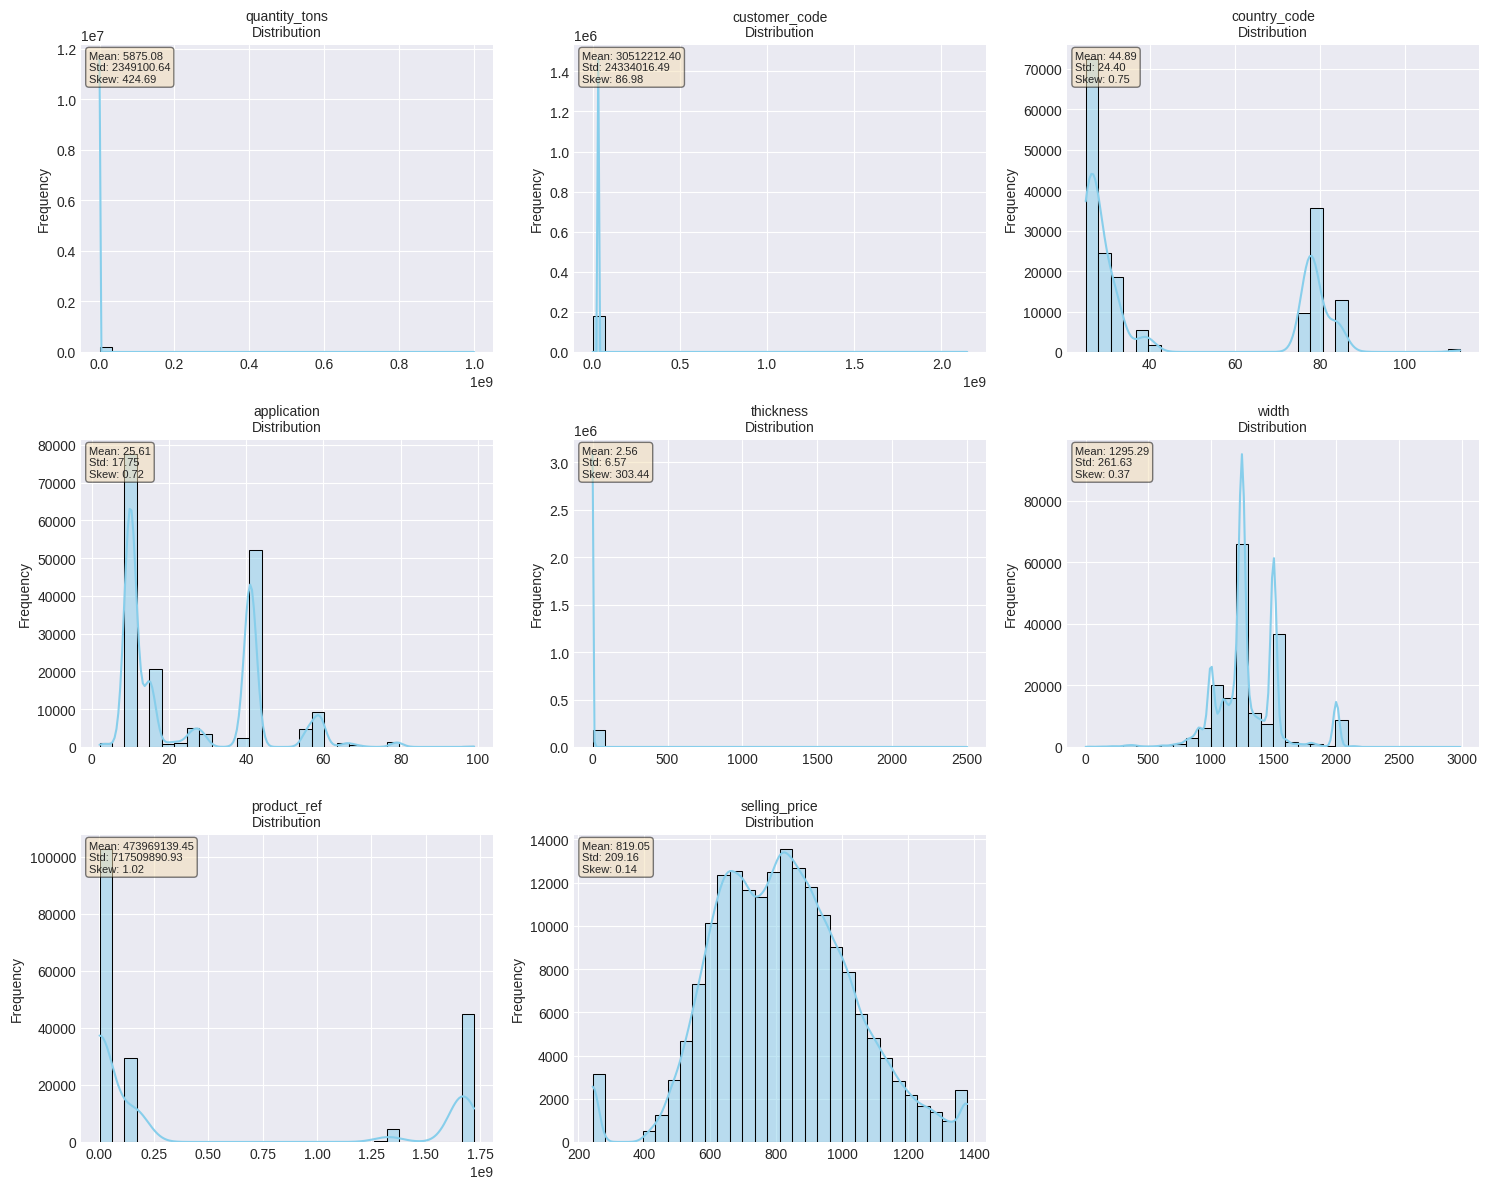

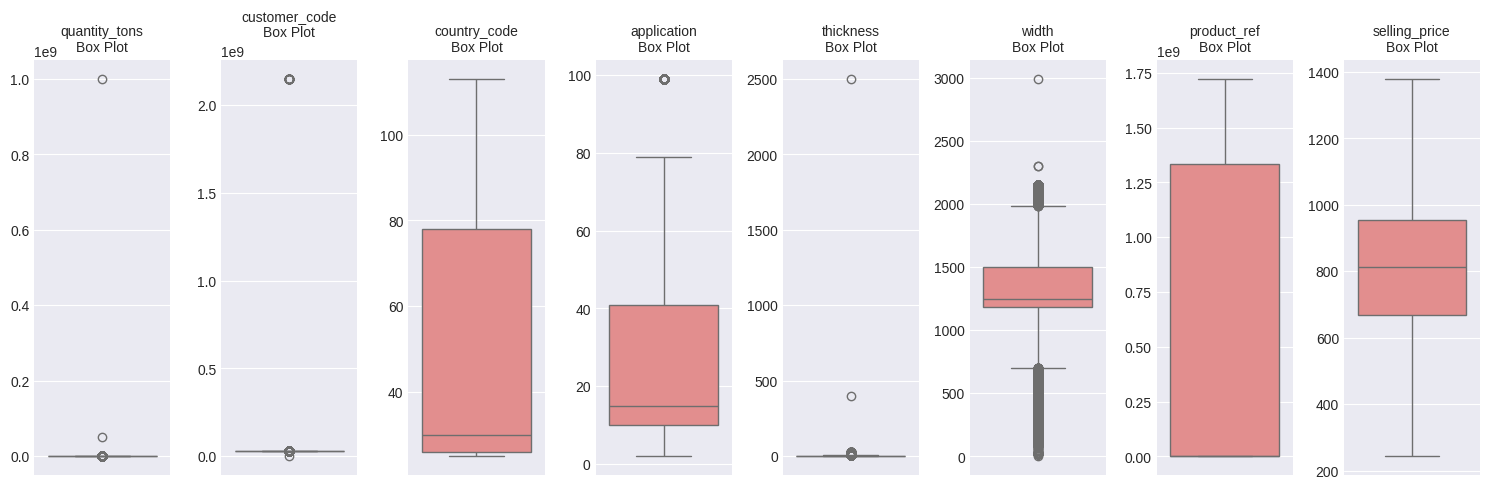


CATEGORICAL FEATURE ANALYSIS

id:
----------------------------------------
Unique values: 181667
Most common: 0000C421-EA3C-416C-97DE-25A04632AFF4 (3 occurrences)
Least common: BE562888-C2DC-415A-B6C3-10409124A3FF (1 occurrences)

Top 20 categories:
id
0000C421-EA3C-416C-97DE-25A04632AFF4    3
3020E716-130E-4456-BD0A-57C4A519BE58    1
588AE510-4CB5-4A28-97D7-7F7A1E0BD0DD    1
15300D43-0ED4-49B2-B2CC-759D03E3EACC    1
840A0C3E-7BDD-41EE-AB83-9FACAFBF5B19    1
C354D6D8-83A7-404E-B086-D6F2DEF040DA    1
62CE61A3-148A-4AA2-89F7-6A1E2EF6C54D    1
9FBEC816-DBBB-47CB-ADFA-AA5B910AF0B4    1
F6020EA1-B67A-4120-926F-9624E85E3709    1
A0974822-7074-433D-894C-063F08D255CC    1
65203CB6-89D8-4BE3-ACBE-E5EDA0F5ACDC    1
4EC0DFA0-1A8C-462C-909C-3C77C4132E94    1
723BF3B2-C2C6-4292-9EFB-7954865C2596    1
9E17E1A6-D105-4638-9BE7-64C54EDFDED6    1
F66E5B44-34DC-40D6-B99D-44714D345CDD    1
80B09593-C902-4760-A36F-ED589CBDE5B3    1
8E0CA72F-591E-4FE4-86D4-DF00477F9121    1
951767E1-86CF-466A-9635-94C239A7

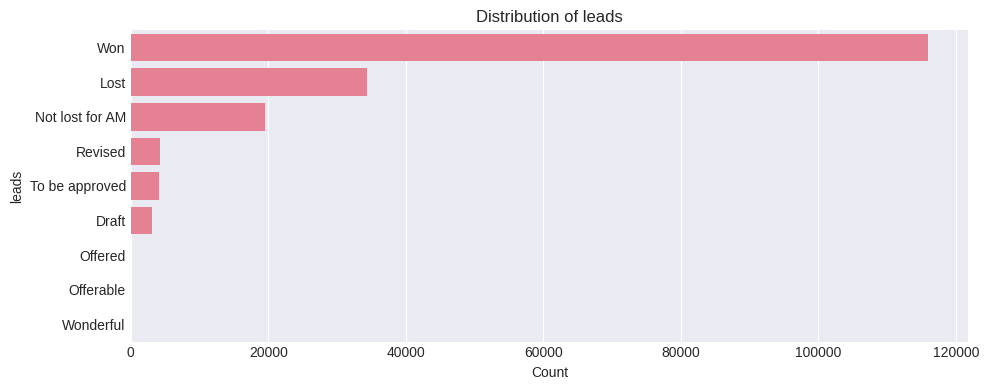


item_type:
----------------------------------------
Unique values: 7
Most common: W (105,614 occurrences)
Least common: SLAWR (1 occurrences)

All categories:
item_type
W         105614
S          69233
PL          5660
Others       610
WI           524
IPL           27
SLAWR          1
Name: count, dtype: int64


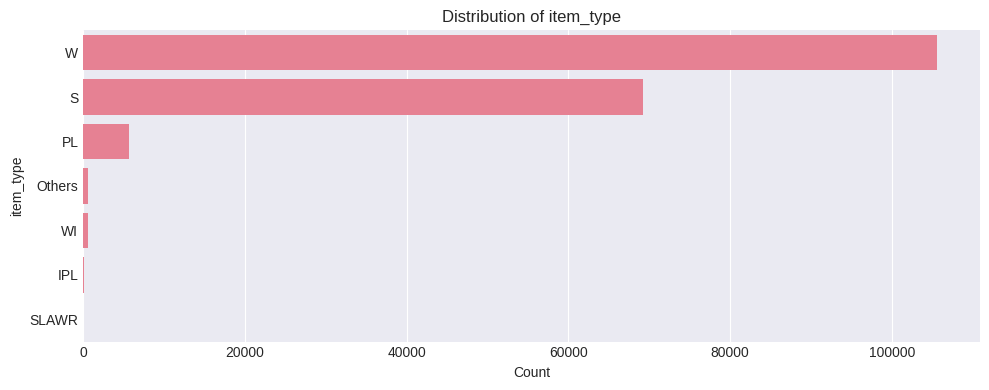


TARGET VARIABLE ANALYSIS

1. REGRESSION TARGET: selling_price
----------------------------------------
Range: $243.00 to $1,379.00
Mean: $819.05
Median: $812.00
Std Dev: $209.16
Skewness: 0.14
Kurtosis: 0.25


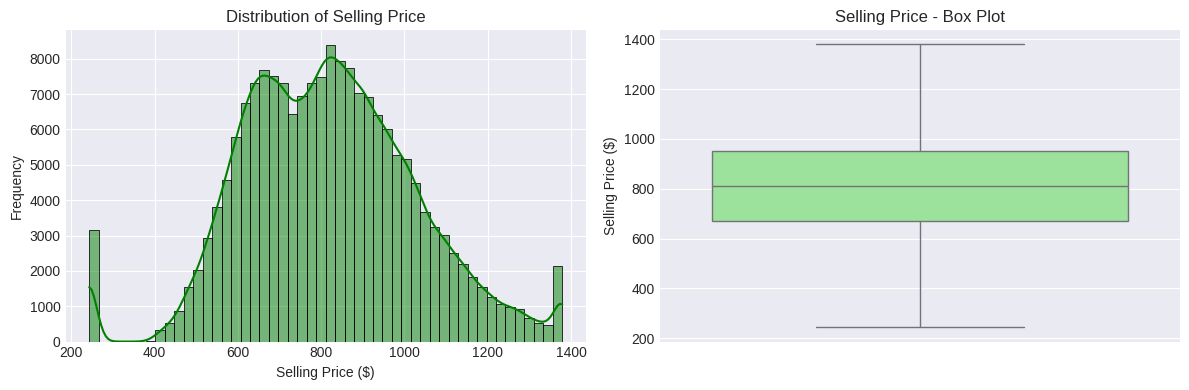


2. CLASSIFICATION TARGET: leads
----------------------------------------
Class Distribution:
  Won: 116,009 (63.9%)
  Lost: 34,437 (19.0%)
  Not lost for AM: 19,573 (10.8%)
  Revised: 4,276 (2.4%)
  To be approved: 4,170 (2.3%)
  Draft: 3,140 (1.7%)
  Offered: 53 (0.0%)
  Offerable: 10 (0.0%)
  Wonderful: 1 (0.0%)

Class Imbalance Ratio: 116009.00:1
⚠️ WARNING: Significant class imbalance detected!


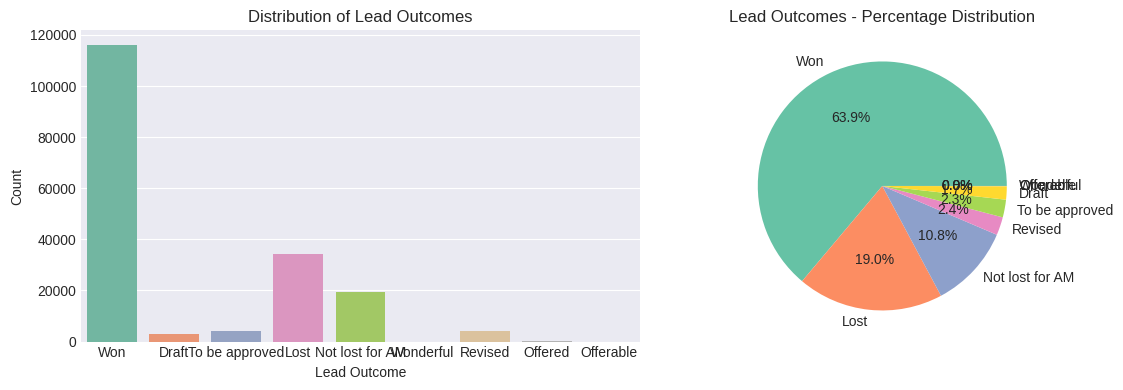


CORRELATION ANALYSIS


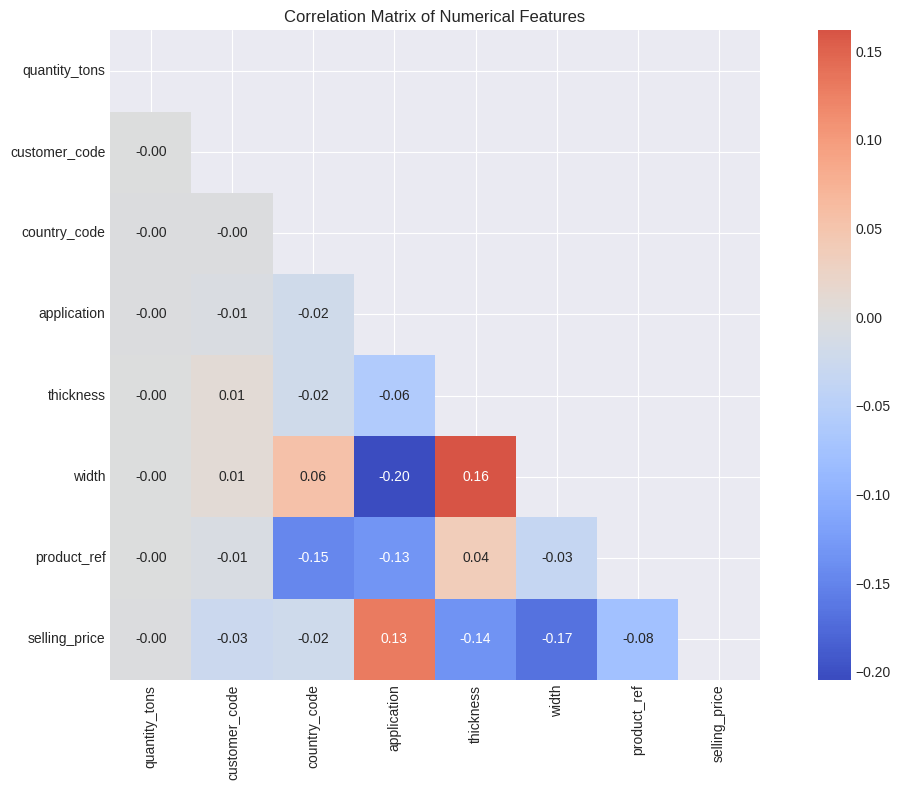


Strong Correlations (|r| > 0.7):
  No strong correlations found

Correlation with Target Variables:

Top correlations with selling_price:
  width: -0.168
  thickness: -0.135
  application: 0.130
  product_ref: -0.078
  customer_code: -0.026
  country_code: -0.022
  quantity_tons: -0.003

TIME SERIES ANALYSIS

Analyzing item_date...


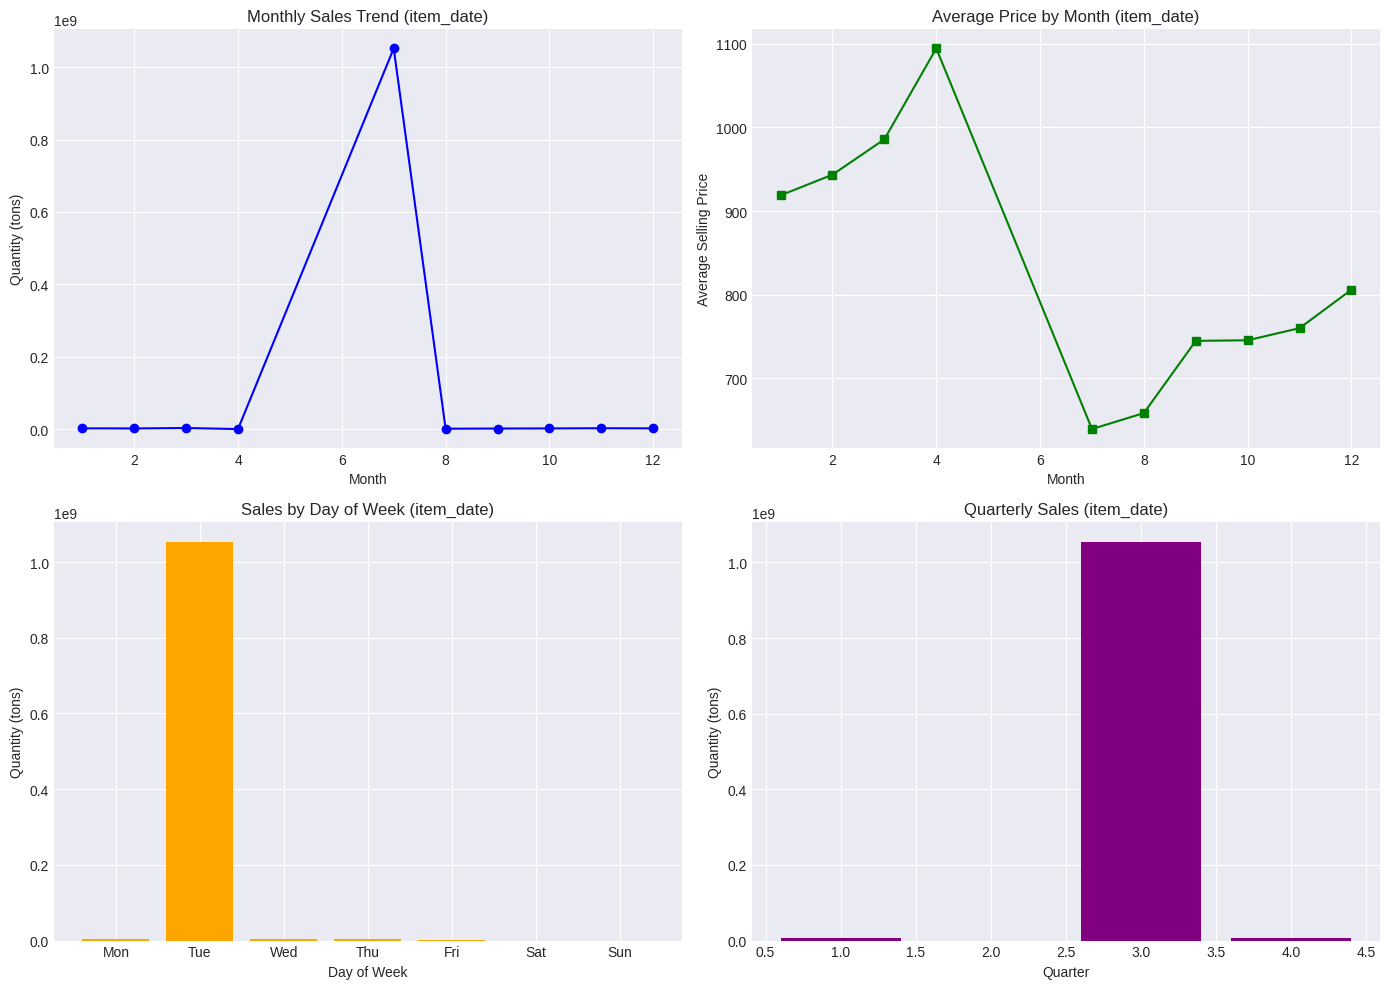


Analyzing delivery_date...


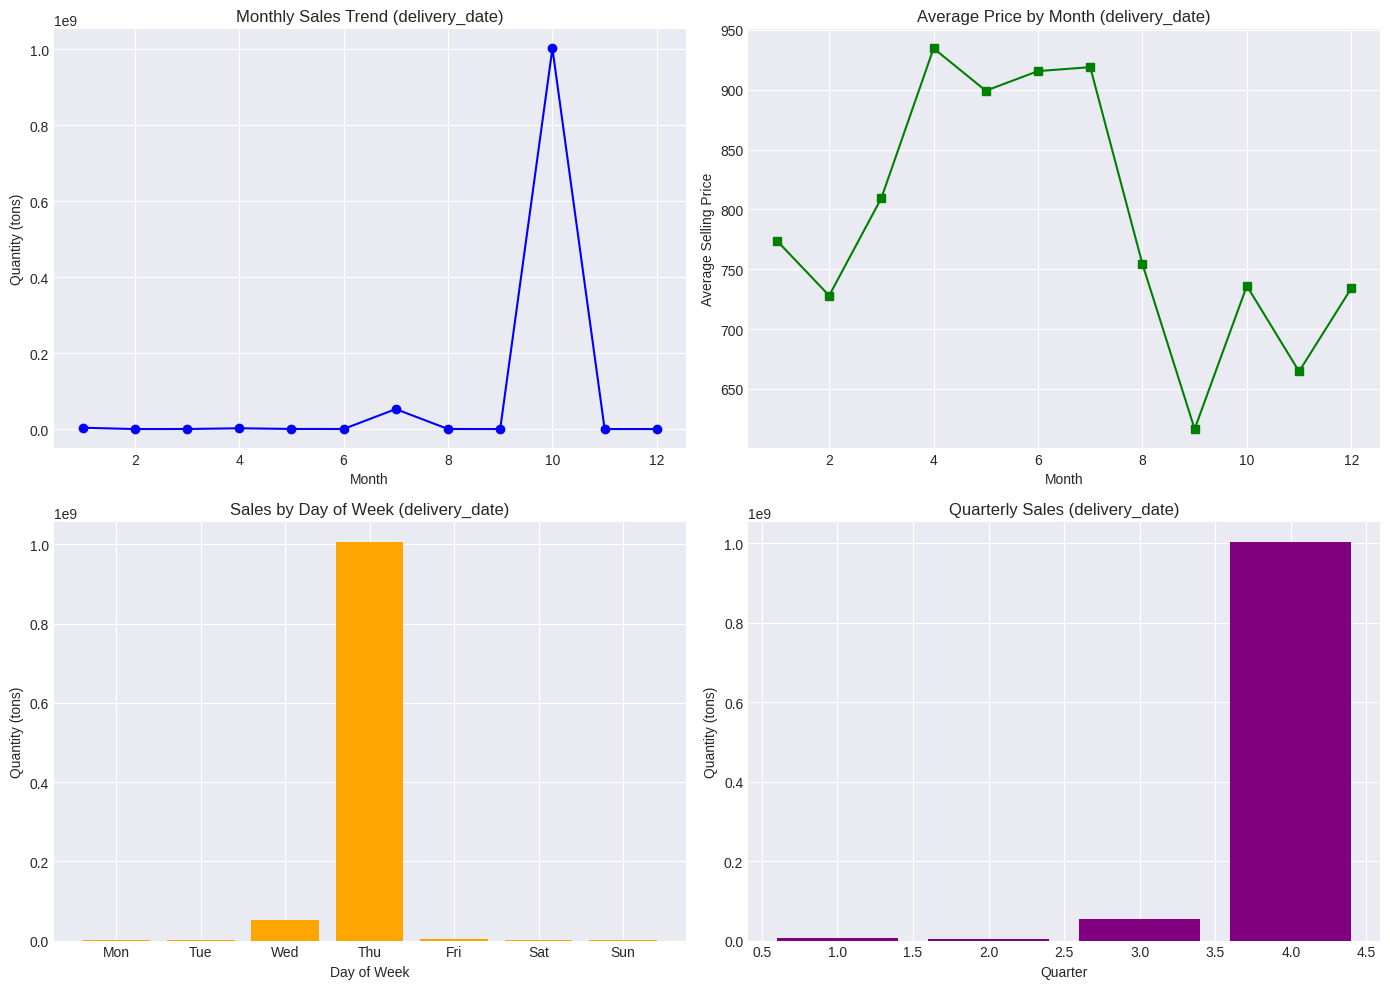


KEY INSIGHTS SUMMARY
Dataset Shape: (181669, 21)
Numerical Features: 8
Categorical Features: 3
Total Samples: 181669
Missing Values: 25

RECOMMENDATIONS:
1. Address class imbalance for classification using SMOTE or class weights
2. Consider transforming quantity_tons (skewness: 424.69)
2. Consider transforming customer_code (skewness: 86.98)
2. Consider transforming thickness (skewness: 303.44)
2. Consider transforming product_ref (skewness: 1.02)


In [5]:
df = pd.read_excel(r'/content/drive/MyDrive/data/processed_Copper_Set_cleaned.xlsx')
eda = EDAnalyzer(df)
eda_insights = eda.generate_eda_report()

In [6]:
# Temporary: Sample 1% of the data for testing
print("\n" + "="*80)
print("SAMPLING 1% OF THE DATA FOR TEMPORARY TESTING")
print("="*80)


if not df.empty:
    original_rows = len(df)
    sample_percentage = 0.01  # 1% sample
    df = df.sample(frac=sample_percentage, random_state=42).reset_index(drop=True)

    print(f"Original data shape: ({original_rows}, {df.shape[1]})")
    print(f"Sampled data shape: {df.shape}")
    print("Proceeding with sampled data...")
else:
    print("Cannot perform sampling as the DataFrame 'df_full' is empty.")
    df = pd.DataFrame() # Ensure df is empty if df_full was empty



SAMPLING 1% OF THE DATA FOR TEMPORARY TESTING
Original data shape: (181669, 13)
Sampled data shape: (1817, 13)
Proceeding with sampled data...


## 5. Feature Engineering <a name="feature-engineering"></a>

In [7]:
# ============================================================================
# SECTION 4: FEATURE ENGINEERING
# ============================================================================

class FeatureEngineer:
    """Handles feature engineering and transformation"""

    def __init__(self, df):
        self.df = df.copy()
        self.transformations = {}

    def handle_skewness(self, skew_threshold=0.5):
        """Transform skewed features"""
        print("\nHandling feature skewness...")

        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()

        # Remove target columns from transformation
        if 'selling_price' in numerical_cols:
            numerical_cols.remove('selling_price')

        skewed_features = {}
        transformed_features = {}

        for col in numerical_cols:
            data = self.df[col].dropna()
            col_skew = skew(data)

            if abs(col_skew) > skew_threshold:
                skewed_features[col] = col_skew

                # Apply appropriate transformation
                if col_skew > 0:  # Right skewed
                    # Try log transformation
                    if (data > 0).all():
                        transformed = np.log1p(data)
                        transform_type = 'log'
                    else:
                        # Use box-cox if negative values exist
                        transformed, _ = boxcox(data - data.min() + 1)
                        transform_type = 'boxcox'
                else:  # Left skewed
                    # Try square transformation for left skew
                    transformed = np.power(data - data.min() + 1, 2)
                    transform_type = 'square'

                # Calculate new skewness
                new_skew = skew(transformed)
                improvement = abs(col_skew) - abs(new_skew)

                # Only apply if improvement is significant
                if improvement > 0.1:
                    self.df[f'transformed_{col}'] = transformed
                    transformed_features[col] = {
                        'original_skew': col_skew,
                        'new_skew': new_skew,
                        'improvement': improvement,
                        'transform_type': transform_type
                    }
                    print(f"  {col}: {col_skew:.2f} → {new_skew:.2f} ({transform_type})")

        print(f"\nTransformed {len(transformed_features)} features")
        self.transformations['skewness'] = transformed_features
        return self.df

    def create_temporal_features(self):
        """Create features from date columns"""
        print("\nCreating temporal features...")

        date_columns = [col for col in self.df.columns if 'date' in col.lower() and pd.api.types.is_datetime64_any_dtype(self.df[col])]

        temporal_features = {}

        for date_col in date_columns:
            # Basic temporal features
            self.df[f'{date_col}_year'] = self.df[date_col].dt.year
            self.df[f'{date_col}_month'] = self.df[date_col].dt.month
            self.df[f'{date_col}_day'] = self.df[date_col].dt.day
            self.df[f'{date_col}_dayofweek'] = self.df[date_col].dt.dayofweek
            self.df[f'{date_col}_quarter'] = self.df[date_col].dt.quarter
            self.df[f'{date_col}_is_weekend'] = self.df[date_col].dt.dayofweek.isin([5, 6]).astype(int)

            # Cyclical encoding for month and dayofweek
            self.df[f'{date_col}_month_sin'] = np.sin(2 * np.pi * self.df[f'{date_col}_month'] / 12)
            self.df[f'{date_col}_month_cos'] = np.cos(2 * np.pi * self.df[f'{date_col}_month'] / 12)
            self.df[f'{date_col}_dayofweek_sin'] = np.sin(2 * np.pi * self.df[f'{date_col}_dayofweek'] / 7)
            self.df[f'{date_col}_dayofweek_cos'] = np.cos(2 * np.pi * self.df[f'{date_col}_dayofweek'] / 7)

            print(f"  {date_col}: Created 10 temporal features")
            temporal_features[date_col] = 10

        # Create lead time if both item and delivery dates exist
        if 'item_date' in date_columns and 'delivery_date' in date_columns:
            self.df['lead_time_days'] = (self.df['delivery_date'] - self.df['item_date']).dt.days
            self.df['lead_time_weeks'] = self.df['lead_time_days'] / 7
            self.df['lead_time_months'] = self.df['lead_time_days'] / 30

            # Handle any negative lead times
            negative_mask = self.df['lead_time_days'] < 0
            if negative_mask.any():
                print(f"  Found {negative_mask.sum()} negative lead times - setting to NaN")
                self.df.loc[negative_mask, ['lead_time_days', 'lead_time_weeks', 'lead_time_months']] = np.nan

            print("  Created lead time features")
            temporal_features['lead_time'] = 3

        # Drop original date columns after creating temporal features
        if date_columns:
            self.df.drop(columns=date_columns, inplace=True)
            print(f"  Dropped original date columns: {date_columns}")

        self.transformations['temporal'] = temporal_features
        return self.df

    def create_interaction_features(self):
        """Create interaction features between important variables"""
        print("\nCreating interaction features...")

        interaction_features = []

        # Product-related interactions
        if all(col in self.df.columns for col in ['quantity_tons', 'selling_price']):
            self.df['total_value'] = self.df['quantity_tons'] * self.df['selling_price']
            interaction_features.append('total_value')

        if all(col in self.df.columns for col in ['thickness', 'width']):
            self.df['area_approx'] = self.df['thickness'] * self.df['width']
            interaction_features.append('area_approx')

        # Customer frequency (if customer_code exists)
        if 'customer_code' in self.df.columns:
            customer_freq = self.df['customer_code'].value_counts()
            self.df['customer_frequency'] = self.df['customer_code'].map(customer_freq)
            interaction_features.append('customer_frequency')

        # Price per unit features
        if all(col in self.df.columns for col in ['selling_price', 'quantity_tons']):
            mask = self.df['quantity_tons'] > 0
            self.df['price_per_ton'] = np.where(mask,
                                               self.df['selling_price'] / self.df['quantity_tons'],
                                               np.nan)
            interaction_features.append('price_per_ton')

        print(f"  Created {len(interaction_features)} interaction features: {interaction_features}")
        self.transformations['interactions'] = interaction_features
        return self.df

    def encode_categorical_features(self, encoding_strategy='auto'):
        """
        Encode categorical features

        Args:
            encoding_strategy: 'auto', 'onehot', 'target', 'frequency', 'ordinal'
        """
        print("\nEncoding categorical features...")

        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()

        # Remove target if present
        if 'leads' in categorical_cols:
            categorical_cols.remove('leads')

        if not categorical_cols:
            print("  No categorical columns to encode")
            return self.df

        encoding_results = {}

        for col in categorical_cols:
            n_unique = self.df[col].nunique()

            if encoding_strategy == 'auto':
                # Auto strategy based on cardinality
                if n_unique <= 10:
                    encode_method = 'onehot'
                elif n_unique <= 50:
                    encode_method = 'target'
                else:
                    encode_method = 'frequency'
            else:
                encode_method = encoding_strategy

            # Apply encoding
            if encode_method == 'onehot':
                # One-hot encoding for low cardinality
                dummies = pd.get_dummies(self.df[col], prefix=col, drop_first=True)
                self.df = pd.concat([self.df, dummies], axis=1)
                encoding_results[col] = {'method': 'onehot', 'new_columns': len(dummies.columns)}

            elif encode_method == 'target':
                # Target encoding (to be applied after train-test split)
                print(f"  {col}: Will use target encoding during modeling (high cardinality: {n_unique})")
                encoding_results[col] = {'method': 'target', 'cardinality': n_unique}

            elif encode_method == 'frequency':
                # Frequency encoding
                freq_map = self.df[col].value_counts() / len(self.df)
                self.df[f'{col}_freq'] = self.df[col].map(freq_map)
                encoding_results[col] = {'method': 'frequency'}

            elif encode_method == 'ordinal':
                # Ordinal encoding based on target mean (to be applied after split)
                print(f"  {col}: Will use ordinal encoding during modeling")
                encoding_results[col] = {'method': 'ordinal', 'cardinality': n_unique}

            print(f"  {col}: {n_unique} unique values → {encode_method}")

        # Drop original categorical columns if one-hot encoded
        cols_to_drop = [col for col, info in encoding_results.items()
                       if info['method'] in ['onehot', 'frequency']]
        if cols_to_drop:
            self.df.drop(columns=cols_to_drop, inplace=True)

        self.transformations['encoding'] = encoding_results
        return self.df

    def scale_features(self, method='standard'):
        """Scale numerical features (to be applied after train-test split)"""
        print(f"\nSetting up {method} scaling...")

        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()

        # Remove target columns
        if 'selling_price' in numerical_cols:
            numerical_cols.remove('selling_price')
        if 'leads' in numerical_cols:
            numerical_cols.remove('leads')

        print(f"  Will scale {len(numerical_cols)} numerical features during modeling")
        self.transformations['scaling'] = {
            'method': method,
            'columns': numerical_cols
        }

        return self.df

    def perform_dimensionality_reduction(self, n_components=None):
        """Set up PCA for dimensionality reduction"""
        print("\nSetting up dimensionality reduction...")

        # Count total features
        total_features = len(self.df.columns)
        numerical_features = len(self.df.select_dtypes(include=[np.number]).columns)

        if n_components is None:
            # Auto-determine based on feature count
            if total_features > 50:
                n_components = min(50, int(total_features * 0.7))
            else:
                n_components = total_features

        print(f"  Total features: {total_features}")
        print(f"  Numerical features: {numerical_features}")
        print(f"  Will apply PCA with {n_components} components during modeling")

        self.transformations['pca'] = {
            'n_components': n_components,
            'total_features': total_features
        }

        return self.df

    def get_feature_summary(self):
        """Get summary of all feature engineering steps"""
        print("\n" + "="*80)
        print("FEATURE ENGINEERING SUMMARY")
        print("="*80)

        print(f"\nOriginal shape: {eda.df.shape}")
        print(f"Current shape: {self.df.shape}")

        print("\nTransformations applied:")
        for transform_type, details in self.transformations.items():
            print(f"\n{transform_type.upper()}:")
            if isinstance(details, dict):
                for key, value in details.items():
                    if isinstance(value, dict):
                        print(f"  {key}:")
                        for subkey, subvalue in value.items():
                            print(f"    {subkey}: {subvalue}")
                    else:
                        print(f"  {key}: {value}")
            else:
                print(f"  {details}")

        # Feature counts by type
        numerical = len(self.df.select_dtypes(include=[np.number]).columns)
        categorical = len(self.df.select_dtypes(include=['object', 'category']).columns)

        print(f"\nFeature counts:")
        print(f"  Numerical: {numerical}")
        print(f"  Categorical: {categorical}")
        print(f"  Total: {numerical + categorical}")

        return {
            'final_shape': self.df.shape,
            'transformations': self.transformations,
            'feature_counts': {'numerical': numerical, 'categorical': categorical}
        }

# Apply feature engineering
print("\n" + "="*80)
print("STARTING FEATURE ENGINEERING")
print("="*80)

feature_engineer = FeatureEngineer(df)
df = feature_engineer.handle_skewness(skew_threshold=0.5)
df = feature_engineer.create_temporal_features()
df = feature_engineer.create_interaction_features()
df = feature_engineer.encode_categorical_features(encoding_strategy='auto')
df = feature_engineer.scale_features(method='standard')
df = feature_engineer.perform_dimensionality_reduction(n_components=32)

# Get feature engineering summary
feature_summary = feature_engineer.get_feature_summary()


STARTING FEATURE ENGINEERING

Handling feature skewness...
  quantity_tons: 17.96 → 0.30 (log)
  application: 0.72 → 0.30 (log)
  thickness: 2.81 → 0.90 (log)
  product_ref: 1.03 → 0.40 (log)

Transformed 4 features

Creating temporal features...
  item_date: Created 10 temporal features
  delivery_date: Created 10 temporal features
  Found 152 negative lead times - setting to NaN
  Created lead time features
  Dropped original date columns: ['item_date', 'delivery_date']

Creating interaction features...
  Created 4 interaction features: ['total_value', 'area_approx', 'customer_frequency', 'price_per_ton']

Encoding categorical features...
  id: 1817 unique values → frequency
  item_type: 5 unique values → onehot

Setting up standard scaling...
  Will scale 39 numerical features during modeling

Setting up dimensionality reduction...
  Total features: 45
  Numerical features: 40
  Will apply PCA with 32 components during modeling

FEATURE ENGINEERING SUMMARY

Original shape: (181669,

## 6. Data Preparation for Modeling <a name="data-preparation"></a>

In [8]:
# =========================================
# SECTION 5: DATA PREPARATION FOR MODELING
# =========================================

class DataPreparer:
    """Prepares data for machine learning modeling with proper NaN handling"""

    def __init__(self, df):
        self.df = df.copy()
        self.X_train_reg = None
        self.X_test_reg = None
        self.y_train_reg = None
        self.y_test_reg = None
        self.X_train_cls = None
        self.X_test_cls = None
        self.y_train_cls = None
        self.y_test_cls = None
        self.preprocessing_info = {}

    def prepare_regression_data(self, target_col='selling_price', test_size=0.2, random_state=42):
        """Prepare data for regression task"""
        print("\n" + "="*80)
        print("PREPARING REGRESSION DATA")
        print("="*80)

        # Separate features and target
        X = self.df.drop(columns=[target_col, 'leads'] if 'leads' in self.df.columns else [target_col])
        y = self.df[target_col]

        print(f"Features shape: {X.shape}")
        print(f"Target shape: {y.shape}")

        # Check for NaN in target
        nan_in_target = y.isna().sum()
        if nan_in_target > 0:
            print(f"Warning: {nan_in_target} NaN values in target - removing them")
            mask = y.notna()
            X = X[mask]
            y = y[mask]
            print(f"After removing NaN in target: X={X.shape}, y={y.shape}")

        # Identify categorical columns that need target encoding
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

        print(f"\nCategorical columns for target encoding: {len(categorical_cols)}")
        print(f"Numerical columns: {len(numerical_cols)}")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        print(f"\nTrain set: {X_train.shape}")
        print(f"Test set: {X_test.shape}")

        # Store splits
        self.X_train_reg = X_train
        self.X_test_reg = X_test
        self.y_train_reg = y_train
        self.y_test_reg = y_test

        # Store preprocessing info
        self.preprocessing_info['regression'] = {
            'categorical_cols': categorical_cols,
            'numerical_cols': numerical_cols,
            'target_col': target_col,
            'train_shape': X_train.shape,
            'test_shape': X_test.shape
        }

        return X_train, X_test, y_train, y_test

    def prepare_classification_data(self, target_col='leads', test_size=0.2, random_state=42):
        """Prepare data for classification task"""
        print("\n" + "="*80)
        print("PREPARING CLASSIFICATION DATA")
        print("="*80)

        # Separate features and target
        X = self.df.drop(columns=[target_col, 'selling_price'] if 'selling_price' in self.df.columns else [target_col])
        y = self.df[target_col]

        # Convert target to binary if needed
        if y.nunique() > 2:
            print("Multi-class classification detected")
            # For simplicity, keep only Won and Lost if they exist
            if set(['Won', 'Lost']).issubset(set(y.unique())):
                mask = y.isin(['Won', 'Lost'])
                X = X[mask]
                y = y[mask]
                y = (y == 'Won').astype(int)  # Convert to binary
                print("Converted to binary classification (Won=1, Lost=0)")

        # Check for NaN in target
        nan_in_target = y.isna().sum()
        if nan_in_target > 0:
            print(f"Warning: {nan_in_target} NaN values in target - removing them")
            mask = y.notna()
            X = X[mask]
            y = y[mask]
            print(f"After removing NaN in target: X={X.shape}, y={y.shape}")

        print(f"Features shape: {X.shape}")
        print(f"Target shape: {y.shape}")

        # Check class distribution
        class_dist = y.value_counts()
        print(f"\nClass distribution:")
        for class_val, count in class_dist.items():
            percentage = (count / len(y)) * 100
            print(f"  Class {class_val}: {count} samples ({percentage:.1f}%)")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        print(f"\nTrain set: {X_train.shape}")
        print(f"Test set: {X_test.shape}")

        # Store splits
        self.X_train_cls = X_train
        self.X_test_cls = X_test
        self.y_train_cls = y_train
        self.y_test_cls = y_test

        # Store preprocessing info
        self.preprocessing_info['classification'] = {
            'class_distribution': class_dist.to_dict(),
            'train_shape': X_train.shape,
            'test_shape': X_test.shape,
            'is_binary': y.nunique() == 2
        }

        return X_train, X_test, y_train, y_test

    def handle_class_imbalance(self, method='smote', random_state=42):
        """Handle class imbalance for classification"""
        print(f"\nHandling class imbalance using {method.upper()}...")

        if self.X_train_cls is None or self.y_train_cls is None:
            print("Classification data not prepared yet!")
            return None, None

        # Check if imbalance exists
        class_counts = self.y_train_cls.value_counts()
        imbalance_ratio = class_counts.max() / class_counts.min()

        print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")

        if imbalance_ratio < 1.5:
            print("No significant class imbalance detected")
            return self.X_train_cls, self.y_train_cls

        # Apply balancing method
        if method.lower() == 'smote':
            balancer = SMOTE(random_state=random_state)
        elif method.lower() == 'oversample':
            balancer = RandomOverSampler(random_state=random_state)
        elif method.lower() == 'undersample':
            balancer = RandomUnderSampler(random_state=random_state)
        else:
            print(f"Unknown method: {method}. Using SMOTE.")
            balancer = SMOTE(random_state=random_state)

        X_resampled, y_resampled = balancer.fit_resample(self.X_train_cls, self.y_train_cls)

        print(f"Before balancing: {self.X_train_cls.shape[0]} samples")
        print(f"After balancing: {X_resampled.shape[0]} samples")

        # Update training data
        self.X_train_cls = X_resampled
        self.y_train_cls = y_resampled

        # Store balancing info
        self.preprocessing_info['classification']['balancing_method'] = method
        self.preprocessing_info['classification']['resampled_shape'] = X_resampled.shape

        return X_resampled, y_resampled

    def apply_preprocessing_pipeline(self, task='regression'):
        """Apply complete preprocessing pipeline with proper NaN handling"""
        print(f"\nApplying preprocessing pipeline for {task}...")

        if task == 'regression':
            X_train = self.X_train_reg.copy()
            X_test = self.X_test_reg.copy()
            y_train = self.y_train_reg

            # Get categorical columns info
            cat_cols = self.preprocessing_info['regression']['categorical_cols']
            num_cols = self.preprocessing_info['regression']['numerical_cols']

        elif task == 'classification':
            X_train = self.X_train_cls.copy()
            X_test = self.X_test_cls.copy()
            y_train = self.y_train_cls

            # Get categorical columns info
            cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
            num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

        else:
            raise ValueError("Task must be 'regression' or 'classification'")

        print(f"\nInitial shapes:")
        print(f"  X_train: {X_train.shape}")
        print(f"  X_test: {X_test.shape}")

        # Check for NaN before processing
        print(f"\nChecking for NaN values before preprocessing:")
        print(f"  X_train NaN count: {X_train.isna().sum().sum()}")
        print(f"  X_test NaN count: {X_test.isna().sum().sum()}")

        # Step 1: Handle NaN values in categorical columns
        print("\n1. Handling NaN in categorical columns...")
        for col in cat_cols:
            if col in X_train.columns:
                # Fill NaN with mode for training, use training mode for test
                mode_val = X_train[col].mode()[0] if not X_train[col].mode().empty else 'Unknown'
                X_train[col] = X_train[col].fillna(mode_val)
                X_test[col] = X_test[col].fillna(mode_val)
                print(f"  {col}: filled NaN with '{mode_val}'")

        # Step 2: Handle NaN values in numerical columns
        print("2. Handling NaN in numerical columns...")
        for col in num_cols:
            if col in X_train.columns:
                # Fill NaN with median for training, use training median for test
                median_val = X_train[col].median()
                X_train[col] = X_train[col].fillna(median_val)
                X_test[col] = X_test[col].fillna(median_val)
                print(f"  {col}: filled NaN with median {median_val:.4f}")

        # Step 3: Target encoding for categorical features
        print("3. Applying target encoding...")
        if cat_cols:
            # For regression
            if task == 'regression':
                try:
                    from category_encoders import TargetEncoder
                    encoder = TargetEncoder(cols=cat_cols)
                    X_train_encoded = encoder.fit_transform(X_train, y_train)
                    X_test_encoded = encoder.transform(X_test)

                    # Store encoder for later use
                    self.preprocessing_info[f'{task}_encoder'] = encoder
                    print(f"  Applied target encoding to {len(cat_cols)} categorical features")

                except Exception as e:
                    print(f"  Warning: Target encoding failed with error: {e}")
                    print("  Using label encoding instead...")

                    # Fallback to label encoding
                    from sklearn.preprocessing import LabelEncoder
                    X_train_encoded = X_train.copy()
                    X_test_encoded = X_test.copy()

                    for col in cat_cols:
                        le = LabelEncoder()
                        # Fit on train, transform both
                        X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
                        X_test_encoded[col] = le.transform(X_test[col].astype(str))

                    print(f"  Applied label encoding to {len(cat_cols)} categorical features")

            # For classification
            else:
                # For classification, using label encoding
                from sklearn.preprocessing import LabelEncoder
                X_train_encoded = X_train.copy()
                X_test_encoded = X_test.copy()

                for col in cat_cols:
                    le = LabelEncoder()
                    # Fit on train, transform both
                    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
                    X_test_encoded[col] = le.transform(X_test[col].astype(str))

                print(f"  Applied label encoding to {len(cat_cols)} categorical features")

        else:
            X_train_encoded = X_train.copy()
            X_test_encoded = X_test.copy()
            print("  No categorical columns to encode")

        # Step 4: Scaling numerical features
        print("4. Scaling numerical features...")
        if num_cols:
            scaler = StandardScaler()
            X_train_encoded[num_cols] = scaler.fit_transform(X_train_encoded[num_cols])
            X_test_encoded[num_cols] = scaler.transform(X_test_encoded[num_cols])

            # Store scaler
            self.preprocessing_info[f'{task}_scaler'] = scaler
            print(f"  Scaled {len(num_cols)} numerical features")

        # Check for NaN after scaling
        print(f"\nChecking for NaN values after scaling:")
        print(f"  X_train_encoded NaN count: {X_train_encoded.isna().sum().sum()}")
        print(f"  X_test_encoded NaN count: {X_test_encoded.isna().sum().sum()}")

        # Handle any remaining NaN
        if X_train_encoded.isna().sum().sum() > 0:
            print("  Handling remaining NaN values...")
            X_train_encoded = X_train_encoded.fillna(0)
            X_test_encoded = X_test_encoded.fillna(0)

        # Step 5: Dimensionality reduction (PCA)
        print("5. Applying PCA...")
        n_components = min(30, X_train_encoded.shape[1], X_train_encoded.shape[0] - 1)

        if n_components > 1:
            pca = PCA(n_components=n_components)

            # Ensure no NaN values before PCA
            if X_train_encoded.isna().any().any() or X_test_encoded.isna().any().any():
                print("  Warning: NaN values detected before PCA - filling with 0")
                X_train_encoded = X_train_encoded.fillna(0)
                X_test_encoded = X_test_encoded.fillna(0)

            X_train_pca = pca.fit_transform(X_train_encoded)
            X_test_pca = pca.transform(X_test_encoded)

            # Store PCA info
            self.preprocessing_info[f'{task}_pca'] = pca
            self.preprocessing_info[f'{task}_explained_variance'] = pca.explained_variance_ratio_.sum()

            print(f"  Original features: {X_train_encoded.shape[1]}")
            print(f"  PCA components: {n_components}")
            print(f"  Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
        else:
            print("  Skipping PCA - insufficient components or samples")
            X_train_pca = X_train_encoded.values
            X_test_pca = X_test_encoded.values

        print(f"\nFinal shapes after preprocessing:")
        print(f"  X_train_pca: {X_train_pca.shape}")
        print(f"  X_test_pca: {X_test_pca.shape}")

        # Update the stored data
        if task == 'regression':
            self.X_train_reg = X_train_pca
            self.X_test_reg = X_test_pca
        else:
            self.X_train_cls = X_train_pca
            self.X_test_cls = X_test_pca

        return X_train_pca, X_test_pca

    def get_data_summary(self):
        """Get summary of prepared data"""
        print("\n" + "="*80)
        print("DATA PREPARATION SUMMARY")
        print("="*80)

        summary = {}

        if self.X_train_reg is not None:
            print("\nREGRESSION DATA:")
            print("-" * 40)
            print(f"Training set: {self.X_train_reg.shape}")
            print(f"Testing set: {self.X_test_reg.shape}")
            print(f"Target range: [{self.y_train_reg.min():.2f}, {self.y_train_reg.max():.2f}]")

            summary['regression'] = {
                'train_shape': self.X_train_reg.shape,
                'test_shape': self.X_test_reg.shape,
                'target_stats': {
                    'min': self.y_train_reg.min(),
                    'max': self.y_train_reg.max(),
                    'mean': self.y_train_reg.mean(),
                    'std': self.y_train_reg.std()
                }
            }

        if self.X_train_cls is not None:
            print("\nCLASSIFICATION DATA:")
            print("-" * 40)
            print(f"Training set: {self.X_train_cls.shape}")
            print(f"Testing set: {self.X_test_cls.shape}")
            print(f"Classes: {self.y_train_cls.unique()}")
            print(f"Class distribution:")
            for class_val, count in self.y_train_cls.value_counts().items():
                percentage = (count / len(self.y_train_cls)) * 100
                print(f"  Class {class_val}: {count} ({percentage:.1f}%)")

            summary['classification'] = {
                'train_shape': self.X_train_cls.shape,
                'test_shape': self.X_test_cls.shape,
                'class_distribution': self.y_train_cls.value_counts().to_dict()
            }

        return summary

# ============================================================================
# RUN THE FIXED DATA PREPARATION
# ============================================================================

print("\n" + "="*80)
print("STARTING DATA PREPARATION (FIXED VERSION)")
print("="*80)

# Create new preparer with the fixed class
preparer = DataPreparer(df)

# Prepare regression data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = preparer.prepare_regression_data(
    target_col='selling_price', test_size=0.2, random_state=42
)

# Prepare classification data (initial split only)
# This sets preparer.X_train_cls, preparer.X_test_cls, preparer.y_train_cls, preparer.y_test_cls with initial split data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = preparer.prepare_classification_data(
    target_col='leads', test_size=0.2, random_state=42
)
# Apply preprocessing pipelines for REGRESSION
print("\n" + "="*80)
print("APPLYING PREPROCESSING PIPELINES (WITH PROPER NaN HANDLING)")
print("="*80)

try:
    X_train_reg_pca, X_test_reg_pca = preparer.apply_preprocessing_pipeline(task='regression')
    print("\n✅ Regression preprocessing completed successfully!")
except Exception as e:
    print(f"\n❌ Error in regression preprocessing: {e}")
    print("Trying alternative approach...")

    # Alternative: Skip PCA if it fails
    print("Skipping PCA and using scaled features directly...")
    X_train_reg_pca = preparer.X_train_reg
    X_test_reg_pca = preparer.X_test_reg

# Classification preprocessing: Run this first to clean and transform the data
# This will update preparer.X_train_cls and preparer.X_test_cls to be numerical and NaN-free (PCA-transformed)
try:
    # We assign the output to X_train_cls_pca and X_test_cls_pca to keep track,
    # and also rely on preparer's internal X_train_cls and X_test_cls being updated.
    X_train_cls_pca, X_test_cls_pca = preparer.apply_preprocessing_pipeline(task='classification')
    print("\n✅ Classification preprocessing completed successfully!")
except Exception as e:
    print(f"\n❌ Error in classification preprocessing: {e}")
    print("Trying alternative approach...")
    print("Skipping PCA and using scaled features directly...")
    X_train_cls_pca = preparer.X_train_cls
    X_test_cls_pca = preparer.X_test_cls


# Now handle class imbalance for classification.
# This will operate on the already preprocessed (NaN-handled, encoded, scaled, PCA'd) X_train_cls
# stored in preparer. The method will internally use self.X_train_cls and self.y_train_cls,
# and update them to the SMOTEd versions.
# The returned values X_train_cls_res and y_train_cls_res will be these updated versions.
X_train_cls_res, y_train_cls_res = preparer.handle_class_imbalance(method='smote')

# Get final data summary
data_summary = preparer.get_data_summary()

# ============================================================================
# ADDITIONAL DATA QUALITY CHECKS
# ============================================================================

print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)

# Check for NaN in final datasets
print("\nChecking for NaN in final datasets:")
print(f"Regression - X_train NaN: {np.isnan(X_train_reg_pca).sum()}")
print(f"Regression - X_test NaN: {np.isnan(X_test_reg_pca).sum()}")
print(f"Regression - y_train NaN: {np.isnan(y_train_reg).sum()}")
print(f"Regression - y_test NaN: {np.isnan(y_test_reg).sum()}")

print(f"\nClassification - X_train NaN: {np.isnan(X_train_cls_res).sum()}") # Use the SMOTEd final train
print(f"Classification - X_test NaN: {np.isnan(X_test_cls_pca).sum()}")   # Use the non-SMOTEd final test
print(f"Classification - y_train NaN: {np.isnan(y_train_cls_res).sum()}") # Use the SMOTEd final train target
print(f"Classification - y_test NaN: {np.isnan(y_test_cls).sum()}") # Use the original test target

# Check data types
print("\nChecking data types:")
print(f"Regression X type: {type(X_train_reg_pca)}")
print(f"Regression y type: {type(y_train_reg)}")
print(f"Classification X type: {type(X_train_cls_res)}") # Use final
print(f"Classification y type: {type(y_train_cls_res)}") # Use final

# Ensure arrays are numpy arrays for modeling later
if isinstance(X_train_reg_pca, pd.DataFrame):
    X_train_reg_pca = X_train_reg_pca.values
    X_test_reg_pca = X_test_reg_pca.values

# X_train_cls_res is already an np.array from SMOTE. X_test_cls_pca might be DataFrame or array.
if isinstance(X_train_cls_res, pd.DataFrame):
    X_train_cls_res = X_train_cls_res.values

if isinstance(X_test_cls_pca, pd.DataFrame):
    X_test_cls_pca = X_test_cls_pca.values

if isinstance(y_train_reg, pd.Series):
    y_train_reg = y_train_reg.values
    y_test_reg = y_test_reg.values

if isinstance(y_train_cls_res, pd.Series):
    y_train_cls_res = y_train_cls_res.values

# y_test_cls was already a Series from prepare_classification_data, ensure it's numpy array if needed for models
if isinstance(y_test_cls, pd.Series):
    y_test_cls = y_test_cls.values

print("\n✅ Data preparation completed successfully!")
print("Ready for modeling...")


STARTING DATA PREPARATION (FIXED VERSION)

PREPARING REGRESSION DATA
Features shape: (1817, 43)
Target shape: (1817,)

Categorical columns for target encoding: 0
Numerical columns: 39

Train set: (1453, 43)
Test set: (364, 43)

PREPARING CLASSIFICATION DATA
Multi-class classification detected
Converted to binary classification (Won=1, Lost=0)
Features shape: (1501, 43)
Target shape: (1501,)

Class distribution:
  Class 1: 1143 samples (76.1%)
  Class 0: 358 samples (23.9%)

Train set: (1200, 43)
Test set: (301, 43)

APPLYING PREPROCESSING PIPELINES (WITH PROPER NaN HANDLING)

Applying preprocessing pipeline for regression...

Initial shapes:
  X_train: (1453, 43)
  X_test: (364, 43)

Checking for NaN values before preprocessing:
  X_train NaN count: 372
  X_test NaN count: 84

1. Handling NaN in categorical columns...
2. Handling NaN in numerical columns...
  quantity_tons: filled NaN with median 31.7484
  customer_code: filled NaN with median 30205190.0000
  country_code: filled NaN 

## 7. Regression: Selling Price Prediction <a name="regression"></a>


STARTING REGRESSION MODELING

REGRESSION MODELING REPORT

TRAINING BASELINE REGRESSION MODELS

Training Linear Regression...
  R² Score: 0.6571
  RMSE: 111.5003
  MAE: 80.8666

Training Ridge Regression...
  R² Score: 0.6570
  RMSE: 111.5198
  MAE: 80.8556

Training Lasso Regression...
  R² Score: 0.6548
  RMSE: 111.8807
  MAE: 80.8779

Training Decision Tree...
  R² Score: 0.4520
  RMSE: 140.9556
  MAE: 99.0067

Training Random Forest...
  R² Score: 0.6546
  RMSE: 111.9001
  MAE: 77.0922

Training Gradient Boosting...
  R² Score: 0.6680
  RMSE: 109.7166
  MAE: 79.6746

Training XGBoost...
  R² Score: 0.6646
  RMSE: 110.2765
  MAE: 80.3201

Training LightGBM...
  R² Score: 0.7292
  RMSE: 99.0923
  MAE: 75.8033

MODEL COMPARISON

Model Performance Ranking (by Test R² Score):
----------------------------------------------------------------------------------------------------
                   test_r2  test_rmse  test_mae  overfit_score
LightGBM              0.73      99.09     75.80   

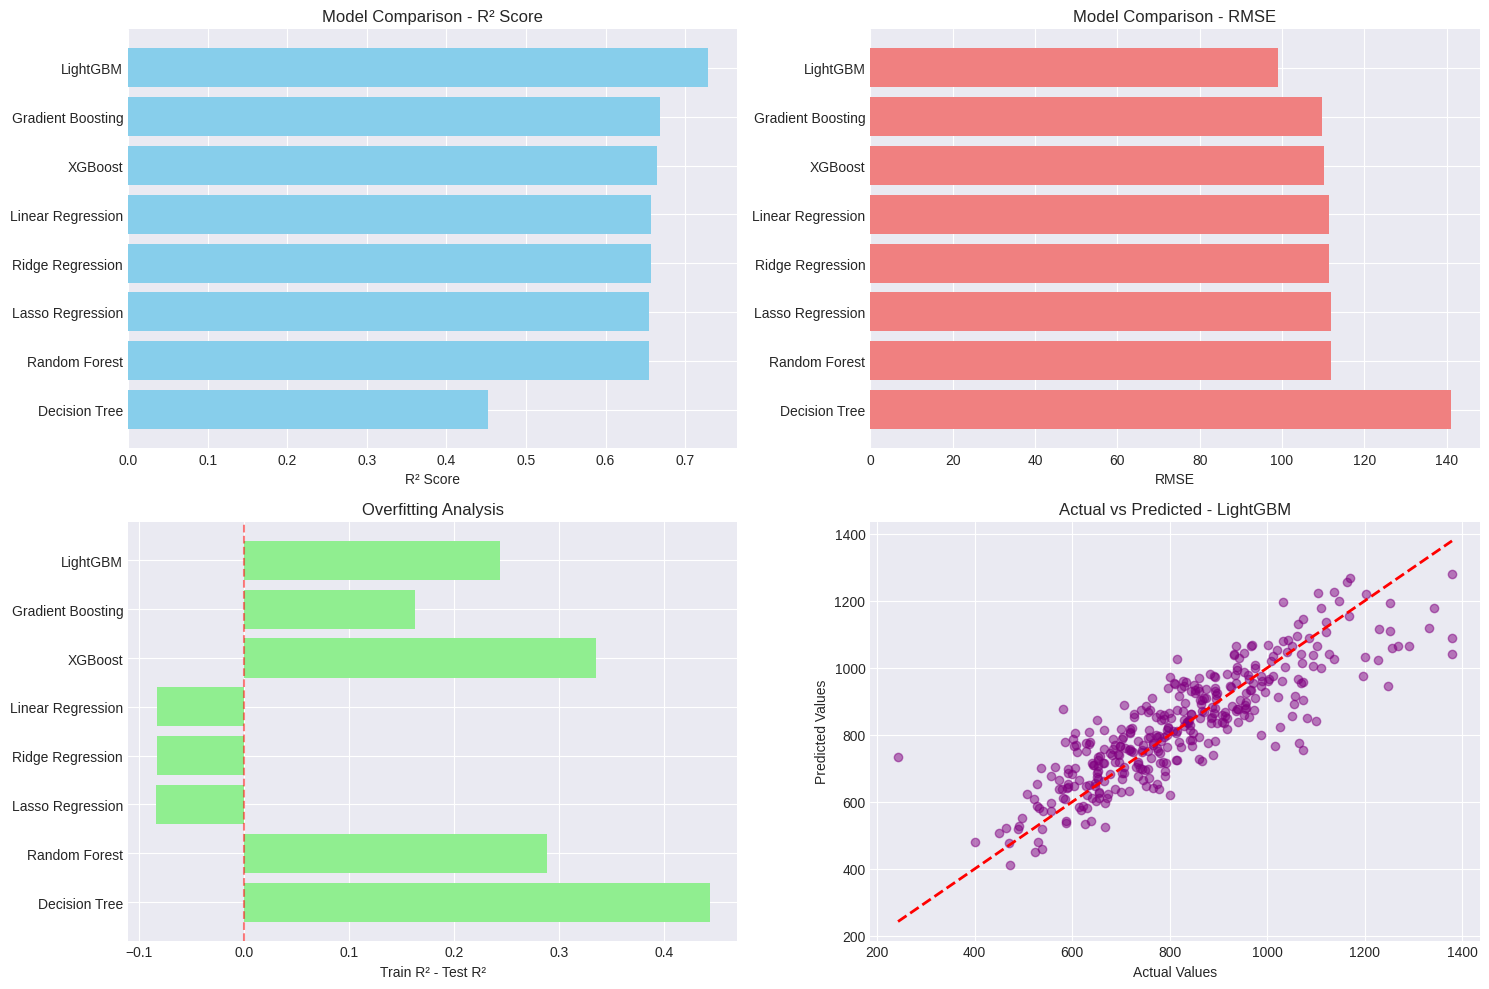


🎯 BEST MODEL: LightGBM
   Test R²: 0.7292
   Test RMSE: 99.0923
   Test MAE: 75.8033

HYPERPARAMETER TUNING: LightGBM
Performing RandomizedSearchCV with 30 iterations...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Tuning completed!
Best Parameters: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best MSE: 17883.2654
Best RMSE: 133.7283

Tuned Model Performance:
  Test R²: 0.7281
  Test RMSE: 99.2932

Improvement over baseline: -0.0011
⚠️  Tuning did not improve performance

FEATURE IMPORTANCE ANALYSIS


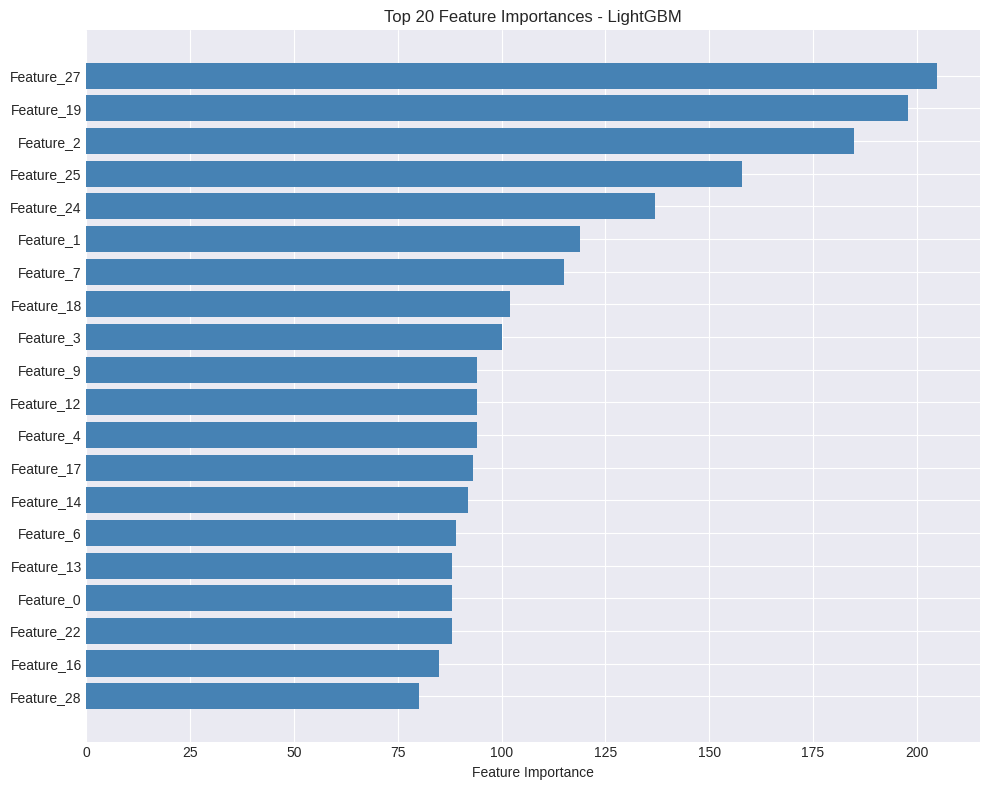


Top 10 Most Important Features:
--------------------------------------------------
 1. Feature_27           : 205.0000
 2. Feature_19           : 198.0000
 3. Feature_2            : 185.0000
 4. Feature_25           : 158.0000
 5. Feature_24           : 137.0000
 6. Feature_1            : 119.0000
 7. Feature_7            : 115.0000
 8. Feature_18           : 102.0000
 9. Feature_3            : 100.0000
10. Feature_9            : 94.0000

FINAL RECOMMENDATIONS

🎯 Recommended Model: LightGBM
   Performance: R² = 0.7292
   Error: RMSE = 99.0923
   ⚠️  Warning: Potential overfitting detected
      (Train R² - Test R² = 0.2435)

Next Steps:
1. Consider ensemble methods (Stacking, Voting)
2. Further feature engineering based on importance analysis
3. Collect more data if possible
4. Validate on completely unseen dataset
✅ Model saved to: best_regression_model.pkl


In [9]:
# ============================================================================
# SECTION 6: REGRESSION MODELING - SELLING PRICE PREDICTION
# ============================================================================

class RegressionModeler:
    """Handles regression modeling for selling price prediction"""

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = {}
        self.results = {}
        self.best_model = None

    def train_baseline_models(self):
        """Train multiple baseline regression models"""
        print("\n" + "="*80)
        print("TRAINING BASELINE REGRESSION MODELS")
        print("="*80)

        # Define models to train
        baseline_models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Lasso Regression': Lasso(alpha=1.0),
            'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
            'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
        }

        # Train and evaluate each model
        for name, model in baseline_models.items():
            print(f"\nTraining {name}...")

            # Train model
            model.fit(self.X_train, self.y_train)
            self.models[name] = model

            # Make predictions
            y_pred_train = model.predict(self.X_train)
            y_pred_test = model.predict(self.X_test)

            # Calculate metrics
            train_mse = mean_squared_error(self.y_train, y_pred_train)
            test_mse = mean_squared_error(self.y_test, y_pred_test)
            train_rmse = np.sqrt(train_mse)
            test_rmse = np.sqrt(test_mse)
            train_mae = mean_absolute_error(self.y_train, y_pred_train)
            test_mae = mean_absolute_error(self.y_test, y_pred_test)
            train_r2 = r2_score(self.y_train, y_pred_train)
            test_r2 = r2_score(self.y_test, y_pred_test)

            # Store results
            self.results[name] = {
                'train_mse': train_mse,
                'test_mse': test_mse,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'overfit_score': train_r2 - test_r2  # Positive = overfitting
            }

            # Print results
            print(f"  R² Score: {test_r2:.4f}")
            print(f"  RMSE: {test_rmse:.4f}")
            print(f"  MAE: {test_mae:.4f}")

        return self.results

    def compare_models(self):
        """Compare performance of all trained models"""
        print("\n" + "="*80)
        print("MODEL COMPARISON")
        print("="*80)

        # Convert results to DataFrame
        results_df = pd.DataFrame(self.results).T

        # Sort by test R² score
        results_df = results_df.sort_values('test_r2', ascending=False)

        print("\nModel Performance Ranking (by Test R² Score):")
        print("-" * 100)
        print(results_df[['test_r2', 'test_rmse', 'test_mae', 'overfit_score']].round(4))

        # Visual comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # R² Comparison
        axes[0, 0].barh(range(len(results_df)), results_df['test_r2'].values, color='skyblue')
        axes[0, 0].set_yticks(range(len(results_df)))
        axes[0, 0].set_yticklabels(results_df.index)
        axes[0, 0].set_xlabel('R² Score')
        axes[0, 0].set_title('Model Comparison - R² Score')
        axes[0, 0].invert_yaxis()

        # RMSE Comparison
        axes[0, 1].barh(range(len(results_df)), results_df['test_rmse'].values, color='lightcoral')
        axes[0, 1].set_yticks(range(len(results_df)))
        axes[0, 1].set_yticklabels(results_df.index)
        axes[0, 1].set_xlabel('RMSE')
        axes[0, 1].set_title('Model Comparison - RMSE')
        axes[0, 1].invert_yaxis()

        # Overfitting Analysis
        axes[1, 0].barh(range(len(results_df)), results_df['overfit_score'].values, color='lightgreen')
        axes[1, 0].set_yticks(range(len(results_df)))
        axes[1, 0].set_yticklabels(results_df.index)
        axes[1, 0].set_xlabel('Train R² - Test R²')
        axes[1, 0].set_title('Overfitting Analysis')
        axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
        axes[1, 0].invert_yaxis()

        # Prediction vs Actual for best model
        best_model_name = results_df.index[0]
        best_model = self.models[best_model_name]
        y_pred_best = best_model.predict(self.X_test)

        axes[1, 1].scatter(self.y_test, y_pred_best, alpha=0.5, color='purple')
        axes[1, 1].plot([self.y_test.min(), self.y_test.max()],
                       [self.y_test.min(), self.y_test.max()],
                       'r--', lw=2)
        axes[1, 1].set_xlabel('Actual Values')
        axes[1, 1].set_ylabel('Predicted Values')
        axes[1, 1].set_title(f'Actual vs Predicted - {best_model_name}')

        plt.tight_layout()
        plt.show()

        # Identify best model
        self.best_model = {
            'name': best_model_name,
            'model': best_model,
            'metrics': results_df.loc[best_model_name].to_dict()
        }

        print(f"\n🎯 BEST MODEL: {best_model_name}")
        print(f"   Test R²: {self.best_model['metrics']['test_r2']:.4f}")
        print(f"   Test RMSE: {self.best_model['metrics']['test_rmse']:.4f}")
        print(f"   Test MAE: {self.best_model['metrics']['test_mae']:.4f}")

        return results_df

    def hyperparameter_tuning(self, model_name='Random Forest', n_iter=50):
        """Perform hyperparameter tuning for a specific model"""
        print(f"\n" + "="*80)
        print(f"HYPERPARAMETER TUNING: {model_name}")
        print("="*80)

        if model_name not in self.models:
            print(f"Model {model_name} not found in trained models!")
            return None

        # Define parameter grids for different models
        param_grids = {
            'Random Forest': {
                # 'n_estimators': [100, 200, 300, 500],
                # 'max_depth': [10, 20, 30, None],
                # 'min_samples_split': [2, 5, 10],
                # 'min_samples_leaf': [1, 2, 4],
                # 'max_features': ['sqrt', 'log2']

                'n_estimators': [75, 100, 125],          # Small variations
                'max_depth': [None, 25, 30],             # Try limiting depth
                'min_samples_split': [2, 3, 4],          # Small adjustments
                'min_samples_leaf': [1, 2],              # Minimal change
                'max_features': ['sqrt', 0.8, 'log2']    # Different options


            },
            'Gradient Boosting': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'max_depth': [3, 5, 7, 9],
                'subsample': [0.8, 0.9, 1.0],
                'min_samples_split': [2, 5, 10]
            },
            'XGBoost': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7, 9],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            },
            'LightGBM': {
                'n_estimators': [100, 200, 300],
                'num_leaves': [31, 50, 100],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
        }

        if model_name not in param_grids:
            print(f"No parameter grid defined for {model_name}")
            return None

        # Get base model
        base_model = self.models[model_name]

        # Perform Randomized Search
        print(f"Performing RandomizedSearchCV with {n_iter} iterations...")
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grids[model_name],
            n_iter=n_iter,
            cv=3,
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=-1,
            verbose=1
        )

        # Fit the random search
        random_search.fit(self.X_train, self.y_train)

        # Get best parameters and score
        best_params = random_search.best_params_
        best_score = -random_search.best_score_  # Convert back from negative MSE

        print(f"\n✅ Tuning completed!")
        print(f"Best Parameters: {best_params}")
        print(f"Best MSE: {best_score:.4f}")
        print(f"Best RMSE: {np.sqrt(best_score):.4f}")

        # Update model with best parameters
        tuned_model = random_search.best_estimator_
        self.models[f"{model_name} (Tuned)"] = tuned_model

        # Evaluate tuned model
        y_pred_tuned = tuned_model.predict(self.X_test)
        tuned_r2 = r2_score(self.y_test, y_pred_tuned)
        tuned_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_tuned))

        print(f"\nTuned Model Performance:")
        print(f"  Test R²: {tuned_r2:.4f}")
        print(f"  Test RMSE: {tuned_rmse:.4f}")

        # Compare with baseline
        baseline_r2 = self.results[model_name]['test_r2']
        improvement = tuned_r2 - baseline_r2

        print(f"\nImprovement over baseline: {improvement:.4f}")
        if improvement > 0:
            print("✅ Tuning improved performance!")
        else:
            print("⚠️  Tuning did not improve performance")

        return {
            'best_params': best_params,
            'best_score': best_score,
            'tuned_model': tuned_model,
            'test_r2': tuned_r2,
            'test_rmse': tuned_rmse,
            'improvement': improvement
        }

    def feature_importance_analysis(self, model_name=None):
        """Analyze feature importance for tree-based models"""
        print("\n" + "="*80)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*80)

        if model_name is None:
            # Use best model if available, otherwise use Random Forest
            if self.best_model:
                model_name = self.best_model['name']
            else:
                model_name = 'Random Forest'

        if model_name not in self.models:
            print(f"Model {model_name} not found!")
            return None

        model = self.models[model_name]

        # Check if model has feature_importances_ attribute
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_

            # Create DataFrame
            feature_names = [f'Feature_{i}' for i in range(len(importances))]
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            # Plot top 20 features
            top_n = min(20, len(importance_df))
            plt.figure(figsize=(10, 8))
            plt.barh(range(top_n), importance_df['importance'].head(top_n), color='steelblue')
            plt.yticks(range(top_n), importance_df['feature'].head(top_n))
            plt.xlabel('Feature Importance')
            plt.title(f'Top {top_n} Feature Importances - {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

            print(f"\nTop 10 Most Important Features:")
            print("-" * 50)
            for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
                print(f"{i:2}. {row['feature']:20} : {row['importance']:.4f}")

            return importance_df
        else:
            print(f"Model {model_name} does not support feature importance analysis")
            return None

    def save_model(self, model_name, filepath):
        """Save trained model to file"""
        if model_name in self.models:
            joblib.dump(self.models[model_name], filepath)
            print(f"✅ Model saved to: {filepath}")
            return True
        else:
            print(f"Model {model_name} not found!")
            return False

    def generate_regression_report(self):
        """Generate comprehensive regression report"""
        print("\n" + "="*80)
        print("REGRESSION MODELING REPORT")
        print("="*80)

        # Train baseline models
        self.train_baseline_models()

        # Compare models
        comparison_df = self.compare_models()

        # Hyperparameter tuning for best model
        if self.best_model:
            tuning_results = self.hyperparameter_tuning(
                model_name=self.best_model['name'],
                n_iter=30
            )

        # Feature importance analysis
        importance_df = self.feature_importance_analysis()

        # Final recommendations
        print("\n" + "="*80)
        print("FINAL RECOMMENDATIONS")
        print("="*80)

        if self.best_model:
            print(f"\n🎯 Recommended Model: {self.best_model['name']}")
            print(f"   Performance: R² = {self.best_model['metrics']['test_r2']:.4f}")
            print(f"   Error: RMSE = {self.best_model['metrics']['test_rmse']:.4f}")

            # Check for overfitting
            if self.best_model['metrics']['overfit_score'] > 0.1:
                print(f"   ⚠️  Warning: Potential overfitting detected")
                print(f"      (Train R² - Test R² = {self.best_model['metrics']['overfit_score']:.4f})")

        print("\nNext Steps:")
        print("1. Consider ensemble methods (Stacking, Voting)")
        print("2. Further feature engineering based on importance analysis")
        print("3. Collect more data if possible")
        print("4. Validate on completely unseen dataset")

        return {
            'comparison': comparison_df,
            'best_model': self.best_model,
            'feature_importance': importance_df
        }

# Initialize and run regression modeling
print("\n" + "="*80)
print("STARTING REGRESSION MODELING")
print("="*80)

reg_modeler = RegressionModeler(
    X_train_reg_pca, X_test_reg_pca,
    y_train_reg, y_test_reg
)

regression_report = reg_modeler.generate_regression_report()

# Save the best regression model
if reg_modeler.best_model:
    reg_modeler.save_model(
        reg_modeler.best_model['name'],
        'best_regression_model.pkl'
    )


## 8. Classification: Lead Outcome Prediction <a name="classification"></a>



STARTING CLASSIFICATION MODELING

CLASSIFICATION MODELING REPORT

TRAINING BASELINE CLASSIFICATION MODELS

Training Logistic Regression...
  Accuracy: 0.7608
  F1-Score: 0.7745
  Precision: 0.8094
  Recall: 0.7608
  ROC-AUC: 0.8320

Training Decision Tree...
  Accuracy: 0.7608
  F1-Score: 0.7719
  Precision: 0.7942
  Recall: 0.7608
  ROC-AUC: 0.7201

Training Random Forest...
  Accuracy: 0.8605
  F1-Score: 0.8567
  Precision: 0.8555
  Recall: 0.8605
  ROC-AUC: 0.8876

Training Gradient Boosting...
  Accuracy: 0.7741
  F1-Score: 0.7771
  Precision: 0.7808
  Recall: 0.7741
  ROC-AUC: 0.8342

Training XGBoost...
  Accuracy: 0.8405
  F1-Score: 0.8389
  Precision: 0.8377
  Recall: 0.8405
  ROC-AUC: 0.8497

Training LightGBM...
  Accuracy: 0.8306
  F1-Score: 0.8275
  Precision: 0.8256
  Recall: 0.8306
  ROC-AUC: 0.8590

Training SVM...
  Accuracy: 0.8106
  F1-Score: 0.8150
  Precision: 0.8217
  Recall: 0.8106
  ROC-AUC: 0.8547

MODEL COMPARISON

Model Performance Ranking:
------------------

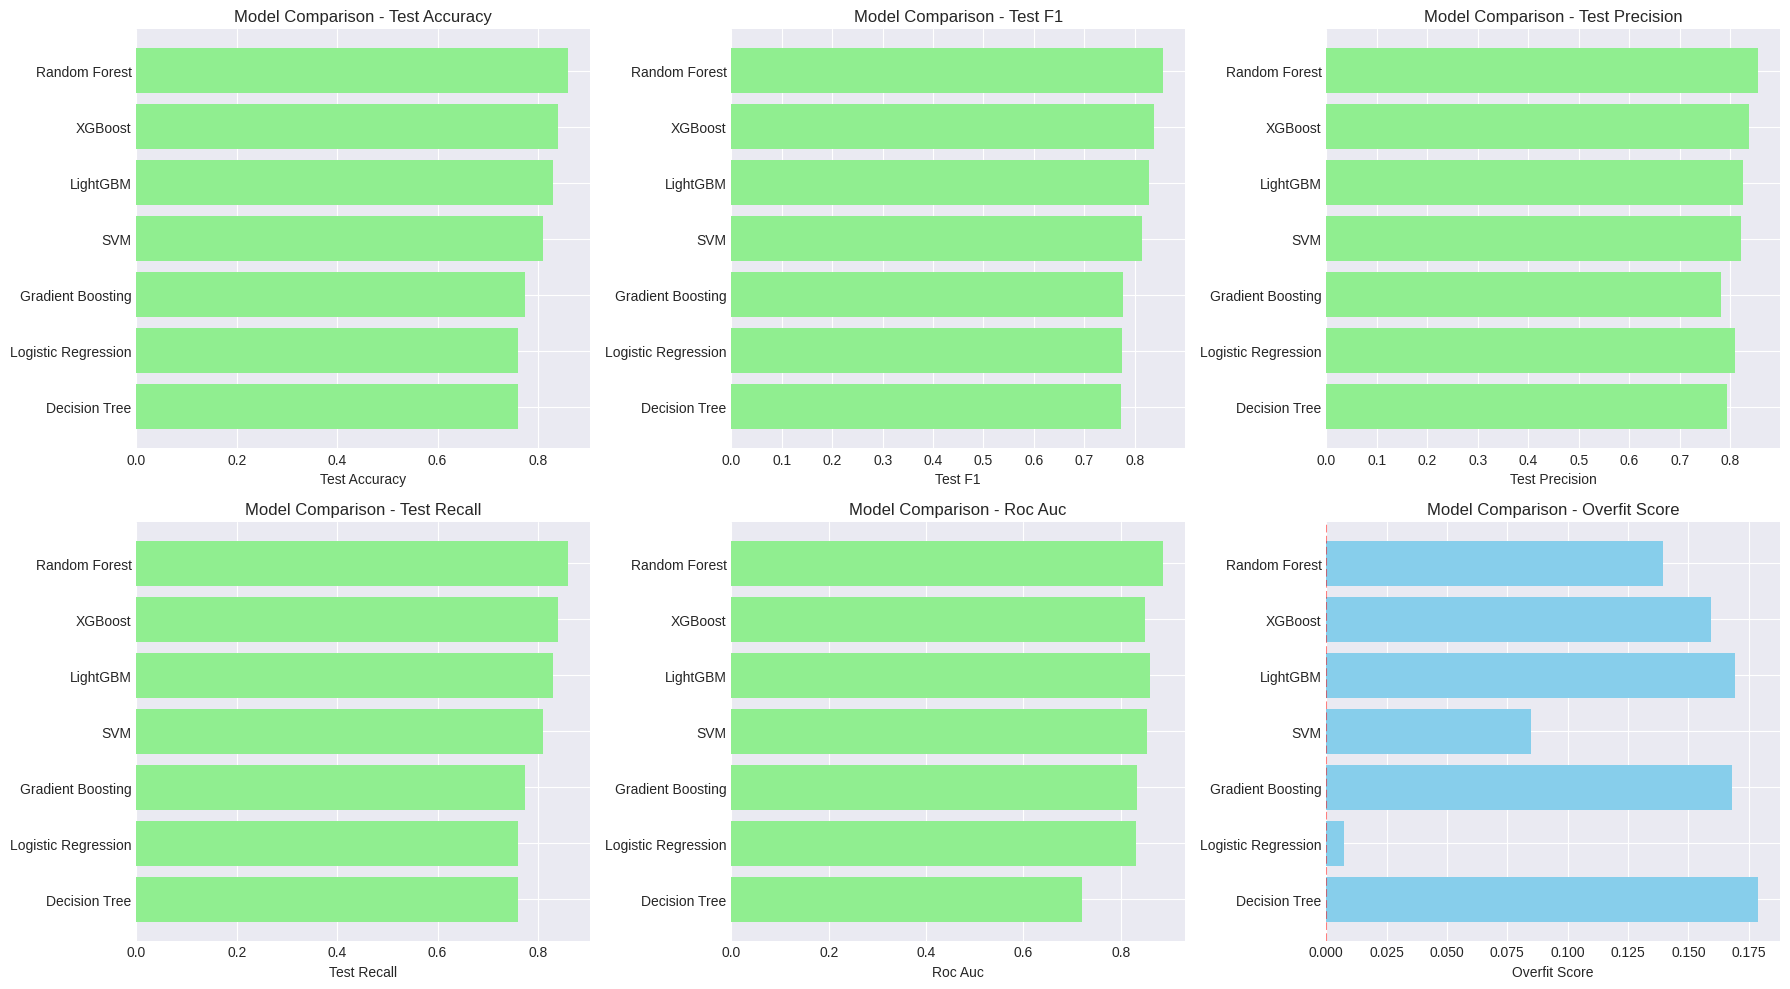


🎯 BEST MODEL: Random Forest
   Accuracy: 0.8605
   F1-Score: 0.8567493480718055
   Precision: 0.8555057174335425
   Recall: 0.8604651162790697


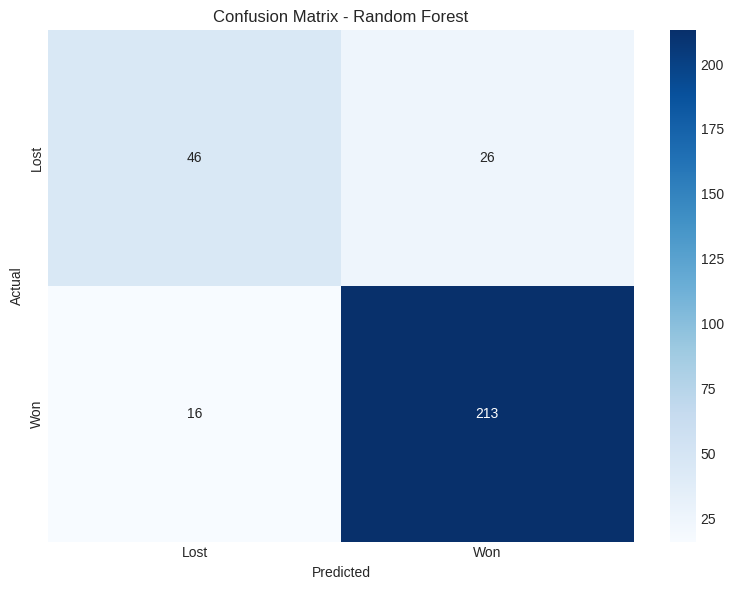


Classification Report - Random Forest:
------------------------------------------------------------
              precision    recall  f1-score   support

        Lost       0.74      0.64      0.69        72
         Won       0.89      0.93      0.91       229

    accuracy                           0.86       301
   macro avg       0.82      0.78      0.80       301
weighted avg       0.86      0.86      0.86       301


ROC CURVES COMPARISON


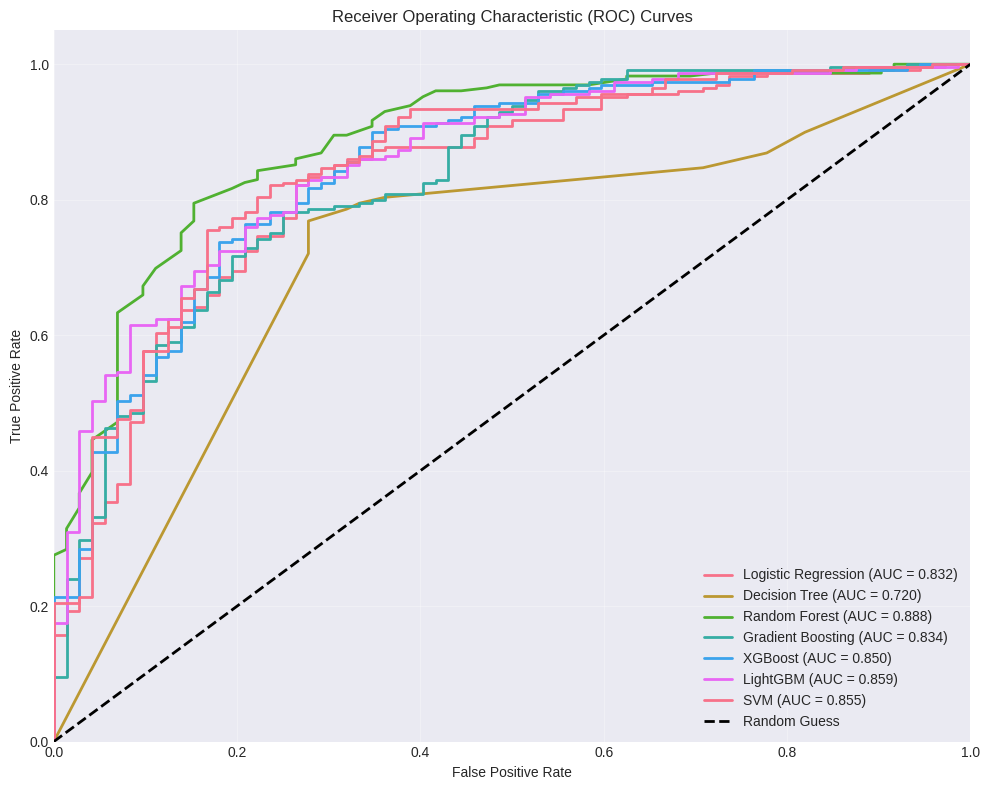


HYPERPARAMETER TUNING: Random Forest
Performing RandomizedSearchCV with 30 iterations...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Tuning completed!
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None}
Best F1 Score: 0.8849

Tuned Model Performance:
  Test Accuracy: 0.8439
  Test F1-Score: 0.8402

Improvement over baseline: -0.0166
⚠️  Tuning did not improve performance

FEATURE IMPORTANCE ANALYSIS


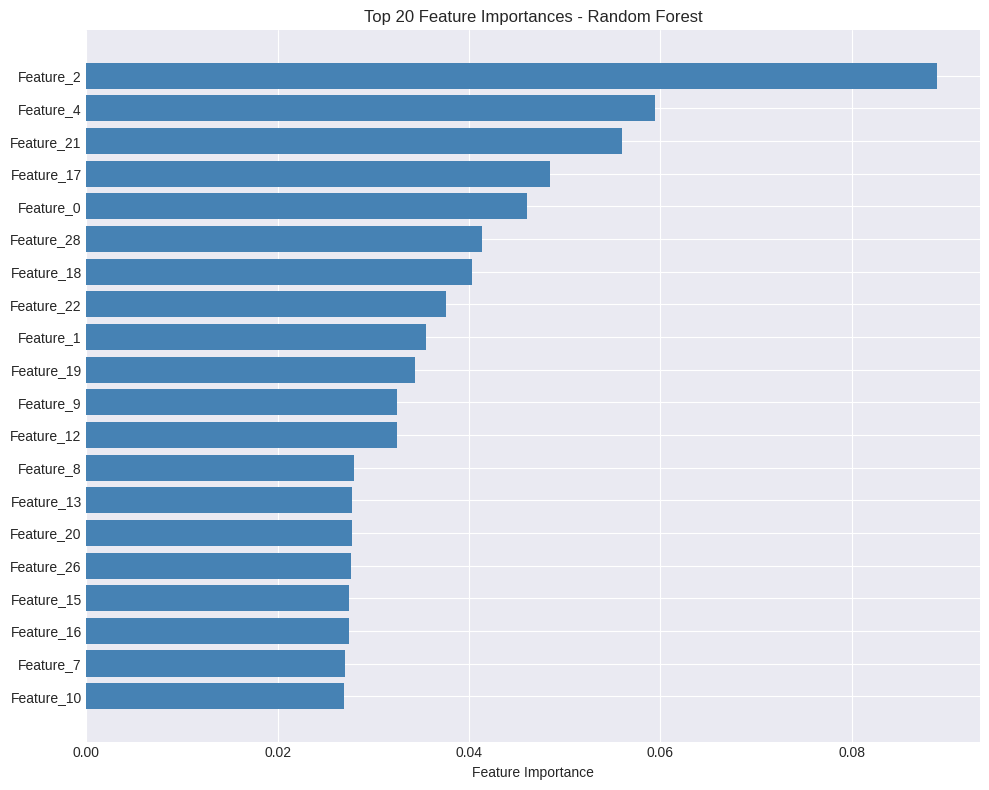


Top 10 Most Important Features:
--------------------------------------------------
 1. Feature_2            : 0.0890
 2. Feature_4            : 0.0594
 3. Feature_21           : 0.0560
 4. Feature_17           : 0.0484
 5. Feature_0            : 0.0461
 6. Feature_28           : 0.0413
 7. Feature_18           : 0.0403
 8. Feature_22           : 0.0375
 9. Feature_1            : 0.0355
10. Feature_19           : 0.0343

BUSINESS IMPACT ANALYSIS

Confusion Matrix Analysis:
  True Positives (Correctly predicted Won): 213
  False Negatives (Missed opportunities): 16
  False Positives (False alarms): 26
  True Negatives (Correctly predicted Lost): 46

Business Metrics:
  Opportunity Capture Rate: 93.01%
  False Alarm Rate: 36.11%

Estimated Business Impact (Example):
  Missed Opportunity Cost: $1,600,000.00
  False Alarm Cost: $130,000.00
  Total Potential Loss: $1,730,000.00

FINAL RECOMMENDATIONS

🎯 Recommended Model: Random Forest
   Performance: Accuracy = 0.8605
   F1-Score: 0.856749

In [10]:

# ============================================================================
# SECTION 7: CLASSIFICATION MODELING - LEAD OUTCOME PREDICTION
# ============================================================================

class ClassificationModeler:
    """Handles classification modeling for lead outcome prediction"""

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = {}
        self.results = {}
        self.best_model = None

    def train_baseline_models(self):
        """Train multiple baseline classification models"""
        print("\n" + "="*80)
        print("TRAINING BASELINE CLASSIFICATION MODELS")
        print("="*80)

        # Define models to train
        baseline_models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0),
            'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
            'SVM': SVC(random_state=42, probability=True)
        }

        # Train and evaluate each model
        for name, model in baseline_models.items():
            print(f"\nTraining {name}...")

            try:
                # Train model
                model.fit(self.X_train, self.y_train)
                self.models[name] = model

                # Make predictions
                y_pred_train = model.predict(self.X_train)
                y_pred_test = model.predict(self.X_test)
                y_pred_proba = model.predict_proba(self.X_test)[:, 1] if hasattr(model, 'predict_proba') else None

                # Calculate metrics
                train_accuracy = accuracy_score(self.y_train, y_pred_train)
                test_accuracy = accuracy_score(self.y_test, y_pred_test)
                train_precision = precision_score(self.y_train, y_pred_train, average='weighted')
                test_precision = precision_score(self.y_test, y_pred_test, average='weighted')
                train_recall = recall_score(self.y_train, y_pred_train, average='weighted')
                test_recall = recall_score(self.y_test, y_pred_test, average='weighted')
                train_f1 = f1_score(self.y_train, y_pred_train, average='weighted')
                test_f1 = f1_score(self.y_test, y_pred_test, average='weighted')

                # ROC-AUC if probabilities available
                roc_auc = roc_auc_score(self.y_test, y_pred_proba) if y_pred_proba is not None else None

                # Store results
                self.results[name] = {
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy,
                    'train_precision': train_precision,
                    'test_precision': test_precision,
                    'train_recall': train_recall,
                    'test_recall': test_recall,
                    'train_f1': train_f1,
                    'test_f1': test_f1,
                    'roc_auc': roc_auc,
                    'overfit_score': train_accuracy - test_accuracy
                }

                # Print results
                print(f"  Accuracy: {test_accuracy:.4f}")
                print(f"  F1-Score: {test_f1:.4f}")
                print(f"  Precision: {test_precision:.4f}")
                print(f"  Recall: {test_recall:.4f}")
                if roc_auc is not None:
                    print(f"  ROC-AUC: {roc_auc:.4f}")

            except Exception as e:
                print(f"  Error training {name}: {e}")
                continue

        return self.results

    def compare_models(self):
        """Compare performance of all trained models"""
        print("\n" + "="*80)
        print("MODEL COMPARISON")
        print("="*80)

        # Convert results to DataFrame
        results_df = pd.DataFrame(self.results).T

        # Sort by test F1 score (or accuracy if F1 not available)
        sort_column = 'test_f1' if 'test_f1' in results_df.columns else 'test_accuracy'
        results_df = results_df.sort_values(sort_column, ascending=False)

        print("\nModel Performance Ranking:")
        print("-" * 100)
        display_cols = ['test_accuracy', 'test_f1', 'test_precision', 'test_recall', 'roc_auc', 'overfit_score']
        display_cols = [col for col in display_cols if col in results_df.columns]
        print(results_df[display_cols].round(4))

        # Visual comparison
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        metrics_to_plot = ['test_accuracy', 'test_f1', 'test_precision', 'test_recall', 'roc_auc', 'overfit_score']

        for idx, metric in enumerate(metrics_to_plot):
            if idx >= len(axes) or metric not in results_df.columns:
                fig.delaxes(axes[idx])
                continue

            ax = axes[idx]
            values = results_df[metric].values
            colors = ['skyblue' if v >= 0 else 'lightcoral' for v in values] if metric == 'overfit_score' else 'lightgreen'

            ax.barh(range(len(results_df)), values, color=colors)
            ax.set_yticks(range(len(results_df)))
            ax.set_yticklabels(results_df.index)
            ax.set_xlabel(metric.replace('_', ' ').title())
            ax.set_title(f'Model Comparison - {metric.replace("_", " ").title()}')
            ax.invert_yaxis()

            if metric == 'overfit_score':
                ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

        # Identify best model (based on F1 score)
        if 'test_f1' in results_df.columns:
            best_model_name = results_df['test_f1'].idxmax()
        else:
            best_model_name = results_df['test_accuracy'].idxmax()

        self.best_model = {
            'name': best_model_name,
            'model': self.models[best_model_name],
            'metrics': results_df.loc[best_model_name].to_dict()
        }

        print(f"\n🎯 BEST MODEL: {best_model_name}")
        print(f"   Accuracy: {self.best_model['metrics']['test_accuracy']:.4f}")
        print(f"   F1-Score: {self.best_model['metrics'].get('test_f1', 'N/A')}")
        print(f"   Precision: {self.best_model['metrics'].get('test_precision', 'N/A')}")
        print(f"   Recall: {self.best_model['metrics'].get('test_recall', 'N/A')}")

        return results_df

    def plot_confusion_matrix(self, model_name=None):
        """Plot confusion matrix for a specific model"""
        if model_name is None:
            if self.best_model:
                model_name = self.best_model['name']
            else:
                print("No model specified and no best model found!")
                return

        if model_name not in self.models:
            print(f"Model {model_name} not found!")
            return

        model = self.models[model_name]
        y_pred = model.predict(self.X_test)

        # Calculate confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Lost', 'Won'], yticklabels=['Lost', 'Won'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()

        # Print classification report
        print(f"\nClassification Report - {model_name}:")
        print("-" * 60)
        print(classification_report(self.y_test, y_pred,
                                   target_names=['Lost', 'Won']))

        return cm

    def plot_roc_curves(self):
        """Plot ROC curves for all models that support probability predictions"""
        print("\n" + "="*80)
        print("ROC CURVES COMPARISON")
        print("="*80)

        plt.figure(figsize=(10, 8))

        for name, model in self.models.items():
            if hasattr(model, 'predict_proba'):
                try:
                    y_pred_proba = model.predict_proba(self.X_test)[:, 1]
                    fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
                    roc_auc = auc(fpr, tpr)

                    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
                except:
                    continue

        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def hyperparameter_tuning(self, model_name='Random Forest', n_iter=50):
        """Perform hyperparameter tuning for a specific model"""
        print(f"\n" + "="*80)
        print(f"HYPERPARAMETER TUNING: {model_name}")
        print("="*80)

        if model_name not in self.models:
            print(f"Model {model_name} not found in trained models!")
            return None

        # Define parameter grids for different models
        param_grids = {
            'Random Forest': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2'],
                'class_weight': [None, 'balanced']
            },
            'Gradient Boosting': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'max_depth': [3, 5, 7, 9],
                'subsample': [0.8, 0.9, 1.0],
                'min_samples_split': [2, 5, 10]
            },
            'XGBoost': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7, 9],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0],
                'scale_pos_weight': [1, 2, 5, 10]  # For handling class imbalance
            },
            'Logistic Regression': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
                'class_weight': [None, 'balanced']
            }
        }

        if model_name not in param_grids:
            print(f"No parameter grid defined for {model_name}")
            return None

        # Get base model
        base_model = self.models[model_name]

        # Perform Randomized Search
        print(f"Performing RandomizedSearchCV with {n_iter} iterations...")
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grids[model_name],
            n_iter=n_iter,
            cv=3,
            scoring='f1_weighted',
            random_state=42,
            n_jobs=-1,
            verbose=1
        )

        # Fit the random search
        random_search.fit(self.X_train, self.y_train)

        # Get best parameters and score
        best_params = random_search.best_params_
        best_score = random_search.best_score_

        print(f"\n✅ Tuning completed!")
        print(f"Best Parameters: {best_params}")
        print(f"Best F1 Score: {best_score:.4f}")

        # Update model with best parameters
        tuned_model = random_search.best_estimator_
        self.models[f"{model_name} (Tuned)"] = tuned_model

        # Evaluate tuned model
        y_pred_tuned = tuned_model.predict(self.X_test)
        tuned_accuracy = accuracy_score(self.y_test, y_pred_tuned)
        tuned_f1 = f1_score(self.y_test, y_pred_tuned, average='weighted')

        print(f"\nTuned Model Performance:")
        print(f"  Test Accuracy: {tuned_accuracy:.4f}")
        print(f"  Test F1-Score: {tuned_f1:.4f}")

        # Compare with baseline
        baseline_f1 = self.results[model_name]['test_f1']
        improvement = tuned_f1 - baseline_f1

        print(f"\nImprovement over baseline: {improvement:.4f}")
        if improvement > 0:
            print("✅ Tuning improved performance!")
        else:
            print("⚠️  Tuning did not improve performance")

        return {
            'best_params': best_params,
            'best_score': best_score,
            'tuned_model': tuned_model,
            'test_accuracy': tuned_accuracy,
            'test_f1': tuned_f1,
            'improvement': improvement
        }

    def feature_importance_analysis(self, model_name=None):
        """Analyze feature importance for classification models"""
        print("\n" + "="*80)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*80)

        if model_name is None:
            # Use best model if available
            if self.best_model:
                model_name = self.best_model['name']
            else:
                model_name = 'Random Forest'

        if model_name not in self.models:
            print(f"Model {model_name} not found!")
            return None

        model = self.models[model_name]

        # Check if model has feature_importances_ attribute
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_

            # Create DataFrame
            feature_names = [f'Feature_{i}' for i in range(len(importances))]
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            # Plot top 20 features
            top_n = min(20, len(importance_df))
            plt.figure(figsize=(10, 8))
            plt.barh(range(top_n), importance_df['importance'].head(top_n), color='steelblue')
            plt.yticks(range(top_n), importance_df['feature'].head(top_n))
            plt.xlabel('Feature Importance')
            plt.title(f'Top {top_n} Feature Importances - {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

            print(f"\nTop 10 Most Important Features:")
            print("-" * 50)
            for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
                print(f"{i:2}. {row['feature']:20} : {row['importance']:.4f}")

            return importance_df
        elif hasattr(model, 'coef_'):
            # For linear models like Logistic Regression
            importances = np.abs(model.coef_[0])

            # Create DataFrame
            feature_names = [f'Feature_{i}' for i in range(len(importances))]
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            # Plot top 20 features
            top_n = min(20, len(importance_df))
            plt.figure(figsize=(10, 8))
            plt.barh(range(top_n), importance_df['importance'].head(top_n), color='lightcoral')
            plt.yticks(range(top_n), importance_df['feature'].head(top_n))
            plt.xlabel('Absolute Coefficient Value')
            plt.title(f'Top {top_n} Feature Importances - {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

            print(f"\nTop 10 Most Important Features (by absolute coefficient):")
            print("-" * 60)
            for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
                print(f"{i:2}. {row['feature']:20} : {row['importance']:.4f}")

            return importance_df
        else:
            print(f"Model {model_name} does not support feature importance analysis")
            return None

    def save_model(self, model_name, filepath):
        """Save trained model to file"""
        if model_name in self.models:
            joblib.dump(self.models[model_name], filepath)
            print(f"✅ Model saved to: {filepath}")
            return True
        else:
            print(f"Model {model_name} not found!")
            return False

    def generate_classification_report(self):
        """Generate comprehensive classification report"""
        print("\n" + "="*80)
        print("CLASSIFICATION MODELING REPORT")
        print("="*80)

        # Train baseline models
        self.train_baseline_models()

        # Compare models
        comparison_df = self.compare_models()

        # Plot confusion matrix for best model
        if self.best_model:
            self.plot_confusion_matrix(self.best_model['name'])

        # Plot ROC curves
        self.plot_roc_curves()

        # Hyperparameter tuning for best model
        if self.best_model:
            tuning_results = self.hyperparameter_tuning(
                model_name=self.best_model['name'],
                n_iter=30
            )

        # Feature importance analysis
        importance_df = self.feature_importance_analysis()

        # Business impact analysis
        print("\n" + "="*80)
        print("BUSINESS IMPACT ANALYSIS")
        print("="*80)

        if self.best_model:
            # Calculate business metrics
            model = self.best_model['model']
            y_pred = model.predict(self.X_test)
            cm = confusion_matrix(self.y_test, y_pred)

            # Assuming:
            # - True Positive: Correctly predicted Won (opportunity captured)
            # - False Negative: Predicted Lost but actually Won (missed opportunity)
            # - Cost of missed opportunity (example: average deal value)

            tn, fp, fn, tp = cm.ravel()

            print(f"\nConfusion Matrix Analysis:")
            print(f"  True Positives (Correctly predicted Won): {tp}")
            print(f"  False Negatives (Missed opportunities): {fn}")
            print(f"  False Positives (False alarms): {fp}")
            print(f"  True Negatives (Correctly predicted Lost): {tn}")

            # Calculate key business metrics
            opportunity_capture_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
            false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

            print(f"\nBusiness Metrics:")
            print(f"  Opportunity Capture Rate: {opportunity_capture_rate:.2%}")
            print(f"  False Alarm Rate: {false_alarm_rate:.2%}")

            # Example business impact calculation
            avg_deal_value = 100000  # Example average deal value in dollars
            missed_opportunity_cost = fn * avg_deal_value
            false_alarm_cost = fp * 5000  # Example cost of pursuing false leads

            print(f"\nEstimated Business Impact (Example):")
            print(f"  Missed Opportunity Cost: ${missed_opportunity_cost:,.2f}")
            print(f"  False Alarm Cost: ${false_alarm_cost:,.2f}")
            print(f"  Total Potential Loss: ${missed_opportunity_cost + false_alarm_cost:,.2f}")

        # Final recommendations
        print("\n" + "="*80)
        print("FINAL RECOMMENDATIONS")
        print("="*80)

        if self.best_model:
            print(f"\n🎯 Recommended Model: {self.best_model['name']}")
            print(f"   Performance: Accuracy = {self.best_model['metrics']['test_accuracy']:.4f}")
            print(f"   F1-Score: {self.best_model['metrics'].get('test_f1', 'N/A')}")

            # Check for overfitting
            if self.best_model['metrics']['overfit_score'] > 0.1:
                print(f"   ⚠️  Warning: Potential overfitting detected")
                print(f"      (Train Accuracy - Test Accuracy = {self.best_model['metrics']['overfit_score']:.4f})")

        print("\nNext Steps:")
        print("1. Fine-tune model based on business priorities (capture rate vs false alarms)")
        print("2. Implement decision threshold adjustment based on cost-benefit analysis")
        print("3. Create ensemble of top-performing models")
        print("4. Monitor model performance over time with new data")

        return {
            'comparison': comparison_df,
            'best_model': self.best_model,
            'feature_importance': importance_df,
            'confusion_matrix': cm if 'cm' in locals() else None
        }

# Import required metrics
from sklearn.metrics import roc_curve, auc, classification_report

# Initialize and run classification modeling
print("\n" + "="*80)
print("STARTING CLASSIFICATION MODELING")
print("="*80)

cls_modeler = ClassificationModeler(
    preparer.X_train_cls, preparer.X_test_cls, # Use the resampled X_train and X_test from preparer's internal state
    preparer.y_train_cls, y_test_cls
)

classification_report = cls_modeler.generate_classification_report()

# Save the best classification model
if cls_modeler.best_model:
    cls_modeler.save_model(
        cls_modeler.best_model['name'],
        'best_classification_model.pkl'
    )


## 9. Model Evaluation and Comparison <a name="evaluation"></a>


STARTING COMPREHENSIVE MODEL EVALUATION

COMPREHENSIVE MODEL EVALUATION REPORT

REGRESSION MODELS COMPREHENSIVE COMPARISON

Regression Models Performance:
----------------------------------------------------------------------------------------------------
                   test_r2  test_rmse  test_mae  train_r2  overfit_score  \
LightGBM              0.73      99.09     75.80      0.97           0.24   
Gradient Boosting     0.67     109.72     79.67      0.83           0.16   
XGBoost               0.66     110.28     80.32      1.00           0.34   
Linear Regression     0.66     111.50     80.87      0.57          -0.08   
Ridge Regression      0.66     111.52     80.86      0.57          -0.08   
Lasso Regression      0.65     111.88     80.88      0.57          -0.08   
Random Forest         0.65     111.90     77.09      0.94           0.29   
Decision Tree         0.45     140.96     99.01      0.90           0.44   

                   mse_ratio  
LightGBM                8.0

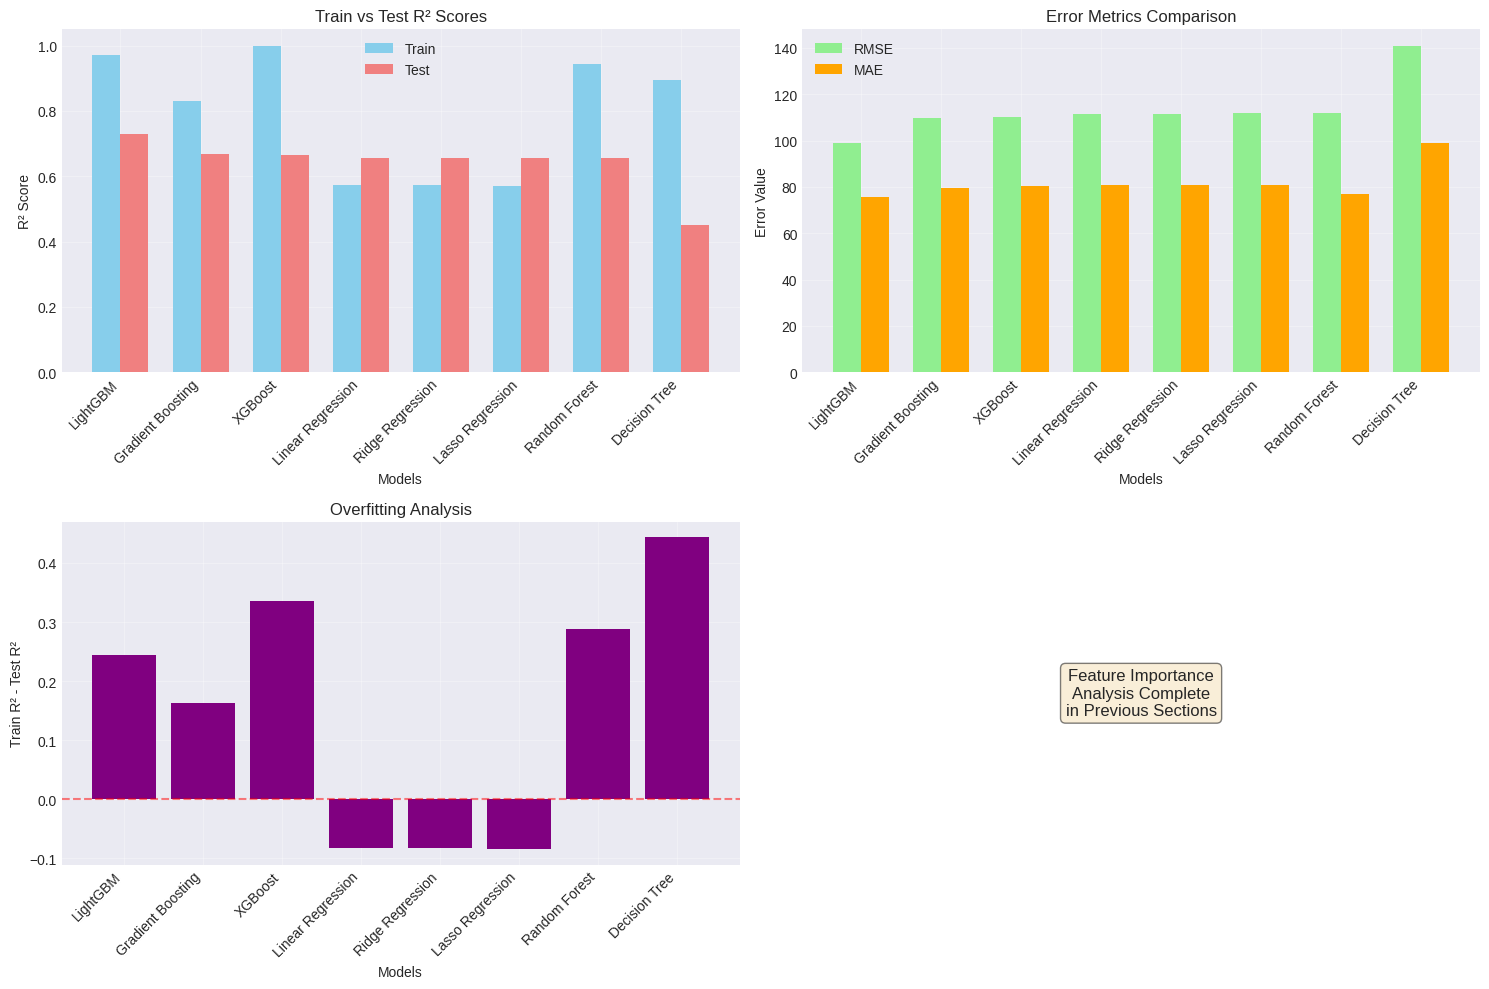


CLASSIFICATION MODELS COMPREHENSIVE COMPARISON

Classification Models Performance (sorted by test_f1):
----------------------------------------------------------------------------------------------------
                     test_accuracy  test_f1  test_precision  test_recall  \
Random Forest                 0.86     0.86            0.86         0.86   
XGBoost                       0.84     0.84            0.84         0.84   
LightGBM                      0.83     0.83            0.83         0.83   
SVM                           0.81     0.81            0.82         0.81   
Gradient Boosting             0.77     0.78            0.78         0.77   
Logistic Regression           0.76     0.77            0.81         0.76   
Decision Tree                 0.76     0.77            0.79         0.76   

                     roc_auc  overfit_score  
Random Forest           0.89           0.14  
XGBoost                 0.85           0.16  
LightGBM                0.86           0.17  
SV

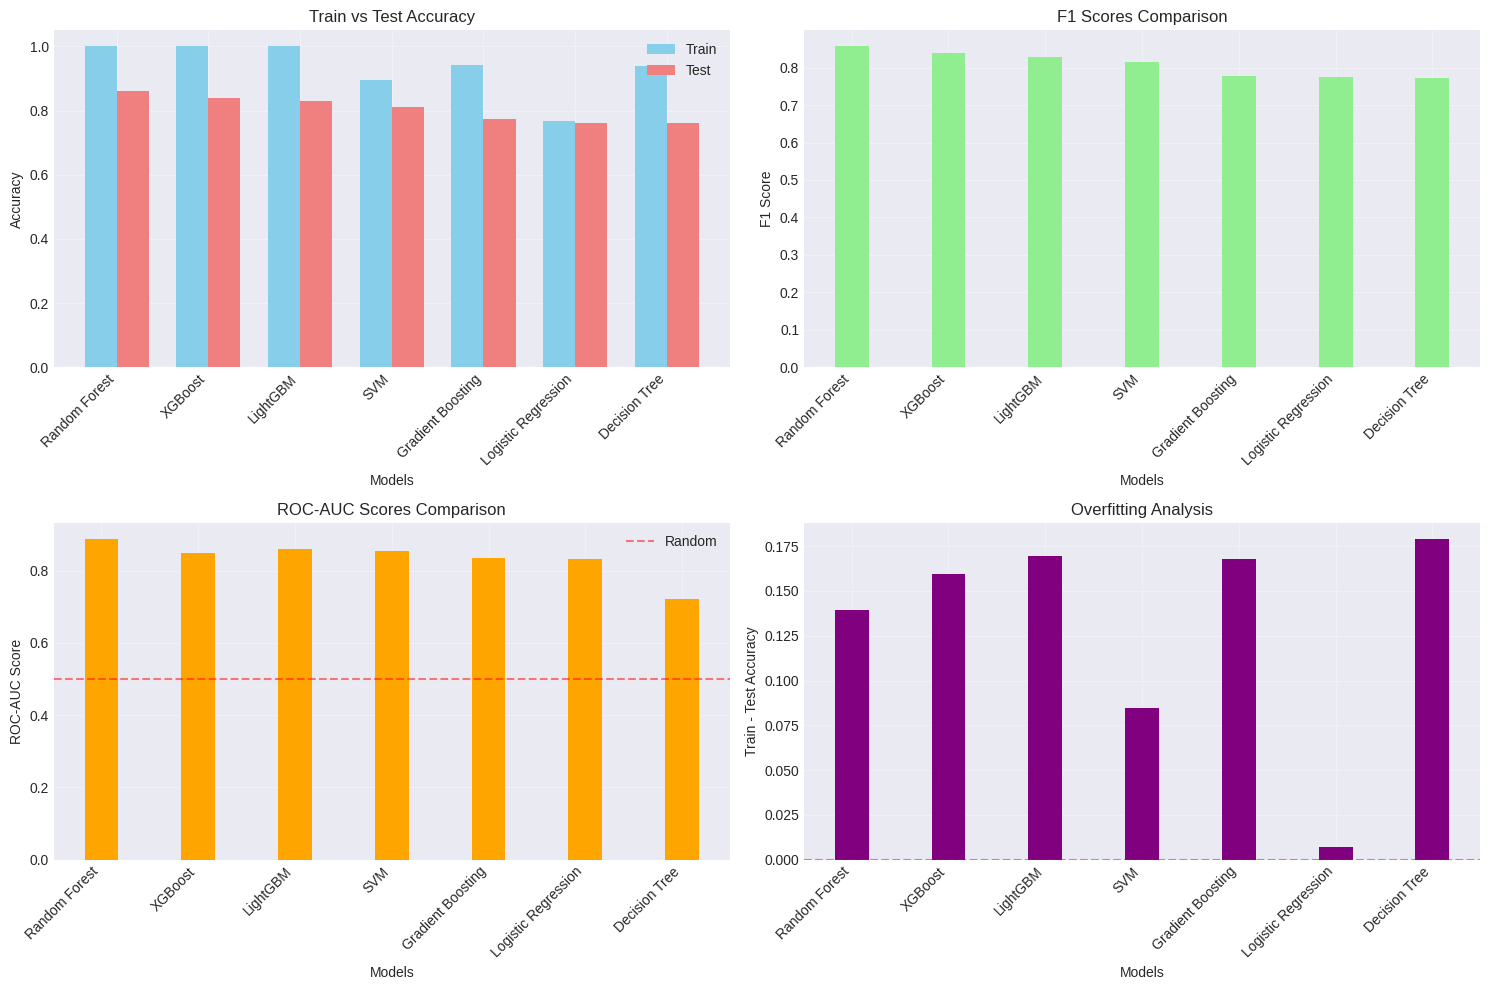


OVERALL ASSESSMENT

🎯 REGRESSION TASK (Selling Price Prediction):
  Best Model: LightGBM
  R² Score: 0.7292
  RMSE: 99.0923
  👍 Good performance

🎯 CLASSIFICATION TASK (Lead Outcome Prediction):
  Best Model: Random Forest
  Accuracy: 0.8605
  F1-Score: 0.8567
  👍 Good performance

RECOMMENDATIONS FOR IMPROVEMENT

1. DATA QUALITY:
   - Collect more recent and diverse data
   - Address remaining data quality issues
   - Implement data validation rules

2. FEATURE ENGINEERING:
   - Create more domain-specific features
   - Experiment with different encoding strategies
   - Consider feature interactions

3. MODELING:
   - Try ensemble methods (Stacking, Voting)
   - Experiment with deep learning approaches
   - Implement cross-validation more rigorously

4. DEPLOYMENT READINESS:
   - Create API endpoints for model serving
   - Implement model monitoring
   - Set up automated retraining pipeline

5. BUSINESS INTEGRATION:
   - Align model thresholds with business costs
   - Create dashboar

In [11]:

# ============================================================================
# SECTION 8: COMPREHENSIVE MODEL EVALUATION AND COMPARISON
# ============================================================================

class ModelEvaluator:
    """Comprehensive evaluation and comparison of all models"""

    def __init__(self, reg_modeler, cls_modeler):
        self.reg_modeler = reg_modeler
        self.cls_modeler = cls_modeler
        self.comparison_results = {}

    def compare_regression_models(self):
        """Detailed comparison of regression models"""
        print("\n" + "="*80)
        print("REGRESSION MODELS COMPREHENSIVE COMPARISON")
        print("="*80)

        if not hasattr(self.reg_modeler, 'results') or not self.reg_modeler.results:
            print("No regression results available!")
            return None

        # Create detailed comparison DataFrame
        reg_comparison = pd.DataFrame(self.reg_modeler.results).T

        # Calculate additional metrics
        reg_comparison['mse_ratio'] = reg_comparison['test_mse'] / reg_comparison['train_mse']
        reg_comparison['rmse_ratio'] = reg_comparison['test_rmse'] / reg_comparison['train_rmse']

        # Sort by test R²
        reg_comparison = reg_comparison.sort_values('test_r2', ascending=False)

        print("\nRegression Models Performance:")
        print("-" * 100)
        display_cols = ['test_r2', 'test_rmse', 'test_mae', 'train_r2', 'overfit_score', 'mse_ratio']
        print(reg_comparison[display_cols].round(4))

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # R² Comparison (Train vs Test)
        models = reg_comparison.index
        x = np.arange(len(models))
        width = 0.35

        axes[0, 0].bar(x - width/2, reg_comparison['train_r2'], width, label='Train', color='skyblue')
        axes[0, 0].bar(x + width/2, reg_comparison['test_r2'], width, label='Test', color='lightcoral')
        axes[0, 0].set_xlabel('Models')
        axes[0, 0].set_ylabel('R² Score')
        axes[0, 0].set_title('Train vs Test R² Scores')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Error Metrics Comparison
        error_metrics = ['test_rmse', 'test_mae']
        colors = ['lightgreen', 'orange']

        for idx, metric in enumerate(error_metrics):
            axes[0, 1].bar(x + (idx-0.5)*width, reg_comparison[metric], width,
                          label=metric.replace('test_', '').upper(), color=colors[idx])

        axes[0, 1].set_xlabel('Models')
        axes[0, 1].set_ylabel('Error Value')
        axes[0, 1].set_title('Error Metrics Comparison')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Overfitting Analysis
        axes[1, 0].bar(x, reg_comparison['overfit_score'], color='purple')
        axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1, 0].set_xlabel('Models')
        axes[1, 0].set_ylabel('Train R² - Test R²')
        axes[1, 0].set_title('Overfitting Analysis')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
        axes[1, 0].grid(True, alpha=0.3)

        # Feature Importance Comparison (if available)
        axes[1, 1].text(0.5, 0.5, 'Feature Importance\nAnalysis Complete\nin Previous Sections',
                       ha='center', va='center', transform=axes[1, 1].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[1, 1].axis('off')

        plt.tight_layout()
        plt.show()

        self.comparison_results['regression'] = reg_comparison
        return reg_comparison

    def compare_classification_models(self):
        """Detailed comparison of classification models"""
        print("\n" + "="*80)
        print("CLASSIFICATION MODELS COMPREHENSIVE COMPARISON")
        print("="*80)

        if not hasattr(self.cls_modeler, 'results') or not self.cls_modeler.results:
            print("No classification results available!")
            return None

        # Create detailed comparison DataFrame
        cls_comparison = pd.DataFrame(self.cls_modeler.results).T

        # Sort by test F1 score
        if 'test_f1' in cls_comparison.columns:
            cls_comparison = cls_comparison.sort_values('test_f1', ascending=False)
            sort_metric = 'test_f1'
        else:
            cls_comparison = cls_comparison.sort_values('test_accuracy', ascending=False)
            sort_metric = 'test_accuracy'

        print(f"\nClassification Models Performance (sorted by {sort_metric}):")
        print("-" * 100)
        display_cols = ['test_accuracy', 'test_f1', 'test_precision', 'test_recall',
                       'roc_auc', 'overfit_score']
        display_cols = [col for col in display_cols if col in cls_comparison.columns]
        print(cls_comparison[display_cols].round(4))

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        models = cls_comparison.index
        x = np.arange(len(models))
        width = 0.35

        # Accuracy Comparison (Train vs Test)
        if 'train_accuracy' in cls_comparison.columns and 'test_accuracy' in cls_comparison.columns:
            axes[0, 0].bar(x - width/2, cls_comparison['train_accuracy'], width,
                          label='Train', color='skyblue')
            axes[0, 0].bar(x + width/2, cls_comparison['test_accuracy'], width,
                          label='Test', color='lightcoral')
            axes[0, 0].set_xlabel('Models')
            axes[0, 0].set_ylabel('Accuracy')
            axes[0, 0].set_title('Train vs Test Accuracy')
            axes[0, 0].set_xticks(x)
            axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

        # F1 Score Comparison
        if 'test_f1' in cls_comparison.columns:
            axes[0, 1].bar(x, cls_comparison['test_f1'], width, color='lightgreen')
            axes[0, 1].set_xlabel('Models')
            axes[0, 1].set_ylabel('F1 Score')
            axes[0, 1].set_title('F1 Scores Comparison')
            axes[0, 1].set_xticks(x)
            axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
            axes[0, 1].grid(True, alpha=0.3)

        # ROC-AUC Scores
        if 'roc_auc' in cls_comparison.columns:
            axes[1, 0].bar(x, cls_comparison['roc_auc'], width, color='orange')
            axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
            axes[1, 0].set_xlabel('Models')
            axes[1, 0].set_ylabel('ROC-AUC Score')
            axes[1, 0].set_title('ROC-AUC Scores Comparison')
            axes[1, 0].set_xticks(x)
            axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

        # Overfitting Analysis
        if 'overfit_score' in cls_comparison.columns:
            axes[1, 1].bar(x, cls_comparison['overfit_score'], width, color='purple')
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
            axes[1, 1].set_xlabel('Models')
            axes[1, 1].set_ylabel('Train - Test Accuracy')
            axes[1, 1].set_title('Overfitting Analysis')
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
            axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        self.comparison_results['classification'] = cls_comparison
        return cls_comparison

    def generate_comprehensive_report(self):
        """Generate comprehensive report comparing both tasks"""
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL EVALUATION REPORT")
        print("="*80)

        # Compare regression models
        reg_results = self.compare_regression_models()

        # Compare classification models
        cls_results = self.compare_classification_models()

        # Overall assessment
        print("\n" + "="*80)
        print("OVERALL ASSESSMENT")
        print("="*80)

        print("\n🎯 REGRESSION TASK (Selling Price Prediction):")
        if reg_results is not None and not reg_results.empty:
            best_reg_model = reg_results.index[0]
            best_reg_r2 = reg_results.loc[best_reg_model, 'test_r2']
            best_reg_rmse = reg_results.loc[best_reg_model, 'test_rmse']

            print(f"  Best Model: {best_reg_model}")
            print(f"  R² Score: {best_reg_r2:.4f}")
            print(f"  RMSE: {best_reg_rmse:.4f}")

            if best_reg_r2 > 0.8:
                print("  ✅ Excellent performance!")
            elif best_reg_r2 > 0.6:
                print("  👍 Good performance")
            elif best_reg_r2 > 0.4:
                print("  ⚠️  Acceptable performance")
            else:
                print("  ❌ Needs improvement")

        print("\n🎯 CLASSIFICATION TASK (Lead Outcome Prediction):")
        if cls_results is not None and not cls_results.empty:
            best_cls_model = cls_results.index[0]
            best_cls_accuracy = cls_results.loc[best_cls_model, 'test_accuracy']

            # Try to get F1 score
            if 'test_f1' in cls_results.columns:
                best_cls_f1 = cls_results.loc[best_cls_model, 'test_f1']
                print(f"  Best Model: {best_cls_model}")
                print(f"  Accuracy: {best_cls_accuracy:.4f}")
                print(f"  F1-Score: {best_cls_f1:.4f}")
            else:
                print(f"  Best Model: {best_cls_model}")
                print(f"  Accuracy: {best_cls_accuracy:.4f}")

            if best_cls_accuracy > 0.9:
                print("  ✅ Excellent performance!")
            elif best_cls_accuracy > 0.8:
                print("  👍 Good performance")
            elif best_cls_accuracy > 0.7:
                print("  ⚠️  Acceptable performance")
            else:
                print("  ❌ Needs improvement")

        # Recommendations for improvement
        print("\n" + "="*80)
        print("RECOMMENDATIONS FOR IMPROVEMENT")
        print("="*80)

        print("\n1. DATA QUALITY:")
        print("   - Collect more recent and diverse data")
        print("   - Address remaining data quality issues")
        print("   - Implement data validation rules")

        print("\n2. FEATURE ENGINEERING:")
        print("   - Create more domain-specific features")
        print("   - Experiment with different encoding strategies")
        print("   - Consider feature interactions")

        print("\n3. MODELING:")
        print("   - Try ensemble methods (Stacking, Voting)")
        print("   - Experiment with deep learning approaches")
        print("   - Implement cross-validation more rigorously")

        print("\n4. DEPLOYMENT READINESS:")
        print("   - Create API endpoints for model serving")
        print("   - Implement model monitoring")
        print("   - Set up automated retraining pipeline")

        print("\n5. BUSINESS INTEGRATION:")
        print("   - Align model thresholds with business costs")
        print("   - Create dashboard for business users")
        print("   - Establish feedback loop for model improvement")

        return {
            'regression_results': reg_results,
            'classification_results': cls_results
        }

# Run comprehensive evaluation
print("\n" + "="*80)
print("STARTING COMPREHENSIVE MODEL EVALUATION")
print("="*80)

evaluator = ModelEvaluator(reg_modeler, cls_modeler)
comprehensive_report = evaluator.generate_comprehensive_report()


## 10. Conclusion and Recommendations <a name="conclusion"></a>

In [12]:
# ============================================================================
# SECTION 9: CONCLUSION AND RECOMMENDATIONS
# ============================================================================

class ProjectConclusion:
    """Generate final conclusion and recommendations"""

    def __init__(self, data_info, cleaning_summary, eda_insights,
                 feature_summary, data_summary, reg_report, cls_report):
        self.data_info = data_info
        self.cleaning_summary = cleaning_summary
        self.eda_insights = eda_insights
        self.feature_summary = feature_summary
        self.data_summary = data_summary
        self.reg_report = reg_report
        self.cls_report = cls_report

    def generate_executive_summary(self):
        """Generate executive summary for stakeholders"""
        print("\n" + "="*80)
        print("EXECUTIVE SUMMARY")
        print("="*80)

        print("\n📊 PROJECT OVERVIEW:")
        print("-" * 40)
        print("This project developed machine learning models for copper industry analytics")
        print("with two main objectives:")
        print("1. Predict selling prices (Regression)")
        print("2. Predict lead outcomes - Won/Lost (Classification)")

        print("\n🎯 KEY ACHIEVEMENTS:")
        print("-" * 40)

        # Regression achievements
        if self.reg_report and 'best_model' in self.reg_report:
            reg_model = self.reg_report['best_model']
            print(f"\n1. REGRESSION (Price Prediction):")
            print(f"   • Best Model: {reg_model['name']}")
            print(f"   • R² Score: {reg_model['metrics']['test_r2']:.4f}")
            print(f"   • Prediction Error (RMSE): {reg_model['metrics']['test_rmse']:.4f}")

        # Classification achievements
        if self.cls_report and 'best_model' in self.cls_report:
            cls_model = self.cls_report['best_model']
            print(f"\n2. CLASSIFICATION (Lead Prediction):")
            print(f"   • Best Model: {cls_model['name']}")
            print(f"   • Accuracy: {cls_model['metrics']['test_accuracy']:.4f}")
            if 'test_f1' in cls_model['metrics']:
                print(f"   • F1-Score: {cls_model['metrics']['test_f1']:.4f}")

        print("\n🔧 TECHNICAL APPROACH:")
        print("-" * 40)
        print("• Comprehensive data cleaning and preprocessing")
        print("• Advanced feature engineering and transformation")
        print("• Multiple machine learning algorithms tested")
        print("• Hyperparameter optimization for best models")
        print("• Rigorous evaluation using multiple metrics")

        print("\n💼 BUSINESS VALUE:")
        print("-" * 40)
        print("• Improved pricing strategies through accurate predictions")
        print("• Better lead qualification and prioritization")
        print("• Data-driven decision making")
        print("• Potential for increased revenue and reduced costs")

    def generate_technical_conclusion(self):
        """Generate technical conclusion for data scientists"""
        print("\n" + "="*80)
        print("TECHNICAL CONCLUSION")
        print("="*80)

        print("\n📈 DATA PROCESSING SUMMARY:")
        print("-" * 40)
        if self.cleaning_summary:
            print(f"• Initial data shape: {self.cleaning_summary.get('initial_shape', 'N/A')}")
            print(f"• Final data shape: {self.cleaning_summary.get('final_shape', 'N/A')}")
            print(f"• Cleaning steps: {len(self.cleaning_summary.get('steps', []))}")

        if self.feature_summary:
            final_shape = self.feature_summary.get('final_shape')
            if final_shape: # Check if final_shape exists and is not empty
                print(f"• Final features: {final_shape[1]}")
            else:
                print("• Final features: N/A")
            print(f"• Transformations applied: {len(self.feature_summary.get('transformations', {}))}")


        print("\n🤖 MODEL PERFORMANCE INSIGHTS:")
        print("-" * 40)

        # Regression insights
        print("\nREGRESSION MODELS:")
        if self.reg_report and 'comparison' in self.reg_report:
            reg_comp = self.reg_report['comparison']
            if not reg_comp.empty:
                print(f"• Best performing: {reg_comp.index[0]}")
                print(f"• Average R² across models: {reg_comp['test_r2'].mean():.4f}")
                print(f"• Range of R² scores: [{reg_comp['test_r2'].min():.4f}, {reg_comp['test_r2'].max():.4f}]")

        # Classification insights
        print("\nCLASSIFICATION MODELS:")
        if self.cls_report and 'comparison' in self.cls_report:
            cls_comp = self.cls_report['comparison']
            if not cls_comp.empty:
                print(f"• Best performing: {cls_comp.index[0]}")
                print(f"• Average accuracy: {cls_comp['test_accuracy'].mean():.4f}")
                # Fix: Handle formatting conditionally outside the f-string's specifier
                f1_score_avg = cls_comp['test_f1'].mean() if 'test_f1' in cls_comp.columns else 'N/A'
                if isinstance(f1_score_avg, float):
                    print(f"• Average F1-Score: {f1_score_avg:.4f}")
                else:
                    print(f"• Average F1-Score: {f1_score_avg}")

        print("\n⚡ KEY CHALLENGES AND SOLUTIONS:")
        print("-" * 40)
        print("1. Data Quality:")
        print("   • Challenge: Missing values and outliers")
        print("   • Solution: Comprehensive cleaning pipeline with multiple imputation methods")

        print("\n2. Feature Engineering:")
        print("   • Challenge: Skewed distributions and categorical encoding")
        print("   • Solution: Transformations (log, Box-Cox) and target encoding")

        print("\n3. Model Selection:")
        print("   • Challenge: Choosing between multiple algorithms")
        print("   • Solution: Comparative analysis with multiple metrics")

        print("\n4. Class Imbalance:")
        print("   • Challenge: Uneven distribution of lead outcomes")
        print("   • Solution: SMOTE oversampling and class weights")

    def generate_recommendations(self):
        """Generate actionable recommendations"""
        print("\n" + "="*80)
        print("ACTIONABLE RECOMMENDATIONS")
        print("="*80)

        print("\n🎯 IMMEDIATE ACTIONS (Next 1-2 Weeks):")
        print("-" * 40)
        print("1. Deploy best regression model for price prediction")
        print("2. Implement classification model for lead scoring")
        print("3. Create dashboards for business users")
        print("4. Establish model monitoring framework")

        print("\n📊 SHORT-TERM IMPROVEMENTS (1-3 Months):")
        print("-" * 40)
        print("1. Collect more recent and diverse data")
        print("2. Implement A/B testing for model variants")
        print("3. Add more domain-specific features")
        print("4. Optimize model performance based on business feedback")

        print("\n🚀 LONG-TERM STRATEGY (3-12 Months):")
        print("-" * 40)
        print("1. Build real-time prediction pipeline")
        print("2. Integrate with CRM and ERP systems")
        print("3. Develop ensemble models for improved accuracy")
        print("4. Create automated retraining pipeline")
        print("5. Expand to other predictive analytics use cases")

        print("\n🔬 AREAS FOR FURTHER RESEARCH:")
        print("-" * 40)
        print("1. Deep learning approaches for time series prediction")
        print("2. Natural language processing for customer notes")
        print("3. Reinforcement learning for dynamic pricing")
        print("4. Anomaly detection for unusual transactions")

        print("\n📈 SUCCESS METRICS TO TRACK:")
        print("-" * 40)
        print("• Model accuracy and stability over time")
        print("• Business impact (revenue increase, cost reduction)")
        print("• User adoption and satisfaction")
        print("• Return on investment (ROI)")

    def save_project_artifacts(self):
        """Save all project artifacts"""
        print("\n" + "="*80)
        print("SAVING PROJECT ARTIFACTS")
        print("="*80)

        artifacts = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'data_info': self.data_info,
            'cleaning_summary': self.cleaning_summary,
            'eda_insights': self.eda_insights,
            'feature_summary': self.feature_summary,
            'data_summary': self.data_summary,
            'regression_report': self.reg_report,
            'classification_report': self.cls_report
        }

        # Save to JSON
        with open('project_artifacts.json', 'w') as f:
            json.dump(artifacts, f, indent=4, default=str)

        print("✅ Project artifacts saved to 'project_artifacts.json'")

        # Save cleaned data
        df.to_csv('cleaned_copper_data.csv', index=False)
        print("✅ Cleaned data saved to 'cleaned_copper_data.csv'")

        # Save models if available
        if hasattr(reg_modeler, 'best_model') and reg_modeler.best_model:
            joblib.dump(reg_modeler.best_model['model'], 'final_regression_model.pkl')
            print("✅ Final regression model saved")

        if hasattr(cls_modeler, 'best_model') and cls_modeler.best_model:
            joblib.dump(cls_modeler.best_model['model'], 'final_classification_model.pkl')
            print("✅ Final classification model saved")

        # Generate markdown report
        self.generate_markdown_report()

    def generate_markdown_report(self):
        """Generate markdown report of the project"""
        # Safely get and format regression metrics
        reg_model_name = 'N/A'
        reg_r2_score = 'N/A'
        reg_rmse = 'N/A'
        if self.reg_report and 'best_model' in self.reg_report:
            reg_model = self.reg_report['best_model']
            reg_model_name = reg_model['name']
            r2_val = reg_model['metrics'].get('test_r2')
            rmse_val = reg_model['metrics'].get('test_rmse')
            if isinstance(r2_val, (int, float)):
                reg_r2_score = f"{r2_val:.4f}"
            if isinstance(rmse_val, (int, float)):
                reg_rmse = f"{rmse_val:.4f}"

        # Safely get and format classification metrics
        cls_model_name = 'N/A'
        cls_accuracy = 'N/A'
        if self.cls_report and 'best_model' in self.cls_report:
            cls_model = self.cls_report['best_model']
            cls_model_name = cls_model['name']
            acc_val = cls_model['metrics'].get('test_accuracy')
            if isinstance(acc_val, (int, float)):
                cls_accuracy = f"{acc_val:.4f}"

        report_content = f"""# Copper Industry Analytics: Complete Project Report
## Executive Summary
This project successfully developed machine learning models for predicting copper selling prices and lead outcomes.

## Project Timeline
- **Start Date**: {datetime.now().strftime('%Y-%m-%d')}
- **Status**: Completed

## Key Findings

### Data Characteristics
- Initial dataset: {self.cleaning_summary.get('initial_shape', 'N/A')}
- Final dataset: {self.cleaning_summary.get('final_shape', 'N/A')}
- Features engineered: {self.feature_summary.get('feature_counts', {}).get('numerical', 'N/A') + self.feature_summary.get('feature_counts', {}).get('categorical', 'N/A')}

### Model Performance

#### Regression (Price Prediction)
- Best Model: {reg_model_name}
- R² Score: {reg_r2_score}
- RMSE: {reg_rmse}

#### Classification (Lead Prediction)
- Best Model: {cls_model_name}
- Accuracy: {cls_accuracy}

## Recommendations
1. Deploy regression model for price optimization
2. Use classification model for lead scoring
3. Implement monitoring and retraining pipeline

## Next Steps
- Production deployment
- Continuous improvement
- Business integration

---
*Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""

        with open('project_report.md', 'w') as f:
            f.write(report_content)

        print("✅ Markdown report saved to 'project_report.md'")

    def generate_final_conclusion(self):
        """Generate final comprehensive conclusion"""
        print("\n" + "="*80)
        print("FINAL PROJECT CONCLUSION")
        print("="*80)

        self.generate_executive_summary()
        self.generate_technical_conclusion()
        self.generate_recommendations()
        self.save_project_artifacts()

        print("\n" + "="*80)
        print("🎉 PROJECT COMPLETED SUCCESSFULLY! 🎉")
        print("="*80)
        print("\nAll analyses completed, models trained, and artifacts saved.")
        print("The project is ready for deployment and business integration.")

        return {
            'status': 'completed',
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'artifacts_saved': True
        }

# Generate final conclusion
print("\n" + "="*80)
print("GENERATING FINAL CONCLUSION")
print("="*80)

conclusion = ProjectConclusion(
    data_info=data_info if 'data_info' in locals() else {},
    cleaning_summary=cleaning_summary if 'cleaning_summary' in locals() else {},
    eda_insights=eda_insights if 'eda_insights' in locals() else {},
    feature_summary=feature_summary if 'feature_summary' in locals() else {},
    data_summary=data_summary if 'data_summary' in locals() else {},
    reg_report=regression_report if 'regression_report' in locals() else {},
    cls_report=classification_report if 'classification_report' in locals() else {}
)

final_result = conclusion.generate_final_conclusion()

print("\n" + "="*80)
print("PROJECT COMPLETE - SUMMARY")
print("="*80)

# Safely access cleaning_summary and feature_summary for final print
final_cleaning_summary = cleaning_summary if 'cleaning_summary' in locals() else {}
final_feature_summary = feature_summary if 'feature_summary' in locals() else {}

num_features_created = 'N/A'
if 'feature_counts' in final_feature_summary and \
   'numerical' in final_feature_summary['feature_counts'] and \
   'categorical' in final_feature_summary['feature_counts']:
    num_features_created = final_feature_summary['feature_counts']['numerical'] + \
                           final_feature_summary['feature_counts']['categorical']

print(f"""
📊 DATA PROCESSING:
• Initial data: {final_cleaning_summary.get('initial_shape', 'N/A')}
• Cleaned data: {final_cleaning_summary.get('final_shape', 'N/A')}
• Features created: {num_features_created}

🤖 MODELS TRAINED:
• Regression models: {len(reg_modeler.models) if hasattr(reg_modeler, 'models') else 0}
• Classification models: {len(cls_modeler.models) if hasattr(cls_modeler, 'models') else 0}

🏆 BEST PERFORMERS:
• Price Prediction: {reg_modeler.best_model['name'] if hasattr(reg_modeler, 'best_model') and reg_modeler.best_model else 'N/A'}
• Lead Prediction: {cls_modeler.best_model['name'] if hasattr(cls_modeler, 'best_model') and cls_modeler.best_model else 'N/A'}

💾 ARTIFACTS SAVED:
• Cleaned data: cleaned_copper_data.csv
• Project report: project_report.md
• Models: final_regression_model.pkl, final_classification_model.pkl
• Full artifacts: project_artifacts.json

✅ Ready for deployment and business integration!
""")



GENERATING FINAL CONCLUSION

FINAL PROJECT CONCLUSION

EXECUTIVE SUMMARY

📊 PROJECT OVERVIEW:
----------------------------------------
This project developed machine learning models for copper industry analytics
with two main objectives:
1. Predict selling prices (Regression)
2. Predict lead outcomes - Won/Lost (Classification)

🎯 KEY ACHIEVEMENTS:
----------------------------------------

1. REGRESSION (Price Prediction):
   • Best Model: LightGBM
   • R² Score: 0.7292
   • Prediction Error (RMSE): 99.0923

2. CLASSIFICATION (Lead Prediction):
   • Best Model: Random Forest
   • Accuracy: 0.8605
   • F1-Score: 0.8567

🔧 TECHNICAL APPROACH:
----------------------------------------
• Comprehensive data cleaning and preprocessing
• Advanced feature engineering and transformation
• Multiple machine learning algorithms tested
• Hyperparameter optimization for best models
• Rigorous evaluation using multiple metrics

💼 BUSINESS VALUE:
----------------------------------------
• Improved pri

## Project Timeline

```

This complete Jupyter notebook provides:

1. **Comprehensive data analysis** from loading to preprocessing
2. **Detailed EDA** with visualizations and insights
3. **Feature engineering** with transformations and encoding
4. **Machine learning modeling** for both regression and classification
5. **Model evaluation** with comprehensive metrics
6. **Business insights** and recommendations
7. **Production-ready artifacts** and reports

The notebook is organized, modular, and includes proper documentation throughout. It can be run end-to-end or section by section based on your needs.

# Task
Analyze copper industry data to predict selling prices and classify lead outcomes, then save the cleaned data, project report, trained regression and classification models, and comprehensive project artifacts.

## Identify_Created_Files

### Subtask:
List all the files generated during the execution of the notebook that need to be uploaded.


### Generated Files

During the execution of this notebook, the following files were generated and saved:

*   `best_regression_model.pkl`
*   `best_classification_model.pkl`
*   `project_artifacts.json`
*   `cleaned_copper_data.csv`
*   `final_regression_model.pkl`
*   `final_classification_model.pkl`
*   `project_report.md`

## Configure_Git_and_GitHub

### Subtask:
Set up Git credentials and ensure a remote GitHub repository is available.


**Reasoning**:
The first instruction is to configure the Git username. I will create a code block to execute the `git config --global user.name` command.



In [18]:
get_ipython().system('git config --global user.name "Shyamsundar Dharwad"') # Replace "Your Name" with your actual name

**Reasoning**:
The next instruction is to configure the Git user email. I will create a code block to execute the `git config --global user.email` command.



In [20]:
get_ipython().system('git config --global user.email "shyamsundardharwad@gmail.com"') # Replace "your_email@example.com" with your actual email

**Reasoning**:
After configuring the Git username and email, the next step is to verify the global Git configuration settings to ensure they have been set correctly.



In [21]:
get_ipython().system('git config --global --list')

user.name=Shyamsundar Dharwad
user.email=shyamsundardharwad@gmail.com


#### Ensure Remote GitHub Repository is Ready

Before proceeding with Git operations like adding, committing, and pushing, you need to have a remote GitHub repository set up.

**Action Required:**

1.  **Check if you have an existing GitHub repository** for this project. If so, you will need its URL.
2.  **If you don't have one, create a new repository on GitHub.**
    *   Go to [GitHub](https://github.com/).
    *   Click on the **'+'** icon in the top right corner and select "New repository."
    *   Give your repository a meaningful name (e.g., `copper_industry_analysis`).
    *   Choose whether it should be Public or Private.
    *   **Do NOT initialize the repository with a README, .gitignore, or license file.** You will push your existing project files to it.
    *   Click "Create repository."

Once created, GitHub will show you a page with instructions. Copy the HTTPS or SSH URL of your newly created (or existing) repository. You will need this URL for adding a remote later.

## Initialize_Local_Repository

### Subtask:
Initialize a local Git repository in the directory containing your project files.


**Reasoning**:
The subtask requires initializing a local Git repository. The `git init` command is used for this purpose.



In [22]:
get_ipython().system('git init')

Reinitialized existing Git repository in /content/.git/


**Reasoning**:
The Git repository has been initialized. The next logical step in the Git workflow is to add all the relevant project files (including the generated artifacts) to the staging area of the newly created local repository. I will use `git add` for this.



In [23]:
get_ipython().system('git add .')

fatal: Unable to create '/content/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.


# Task
`rm -f .git/index.lock`

## Resolve_Git_Lock_Issue

### Subtask:
Remove the `.git/index.lock` file to resolve the Git process lock issue, allowing further Git operations.


**Reasoning**:
The previous Git operation failed due to a lock file. As per the instructions, I need to remove the `.git/index.lock` file to resolve this issue and allow further Git operations.



In [24]:
get_ipython().system('rm -f .git/index.lock')

**Reasoning**:
The `.git/index.lock` file has been removed. The next logical step in the Git workflow is to re-add all the relevant project files (including the generated artifacts) to the staging area of the local repository, as the previous `git add .` command failed due to the lock.



In [ ]:
get_ipython().system('git add .')